# Zillow Prize: Zillow’s Home Value Prediction (Zestimate)

# 0. Introduction
- - -

## Setup

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()

from IPython.display import Image
from IPython.core.pylabtools import figsize
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.model_selection import KFold
from ggplot import *

import missingno as msno
import gc
%matplotlib inline

/usr/local/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


## Zillow
    미국의 온라인 부동산 거래 플랫폼. 2006년 설립.


## Zestimate

    - Zillow의 각 가구의 부동산 가치를 분석하는 머신러닝 모델.
    - 약 1억 가구의 데이터를 기반으로 부동산 가치를 예측한다.
    - Estimation error을 14%에서 5%까지 줄였다. (2018년 1월 기준)


## Objective

    - Zestimate의 log error를 예측하는 모델을 만든다.
    
        October 2016 (201610)
        November 2016 (201611)
        December 2016 (201612)
        October 2017 (201710)
        November 2017 (201711)
        December 2017 (201712)
    
- - -

    - Log error에 영향을 주는 특성을 찾는다.

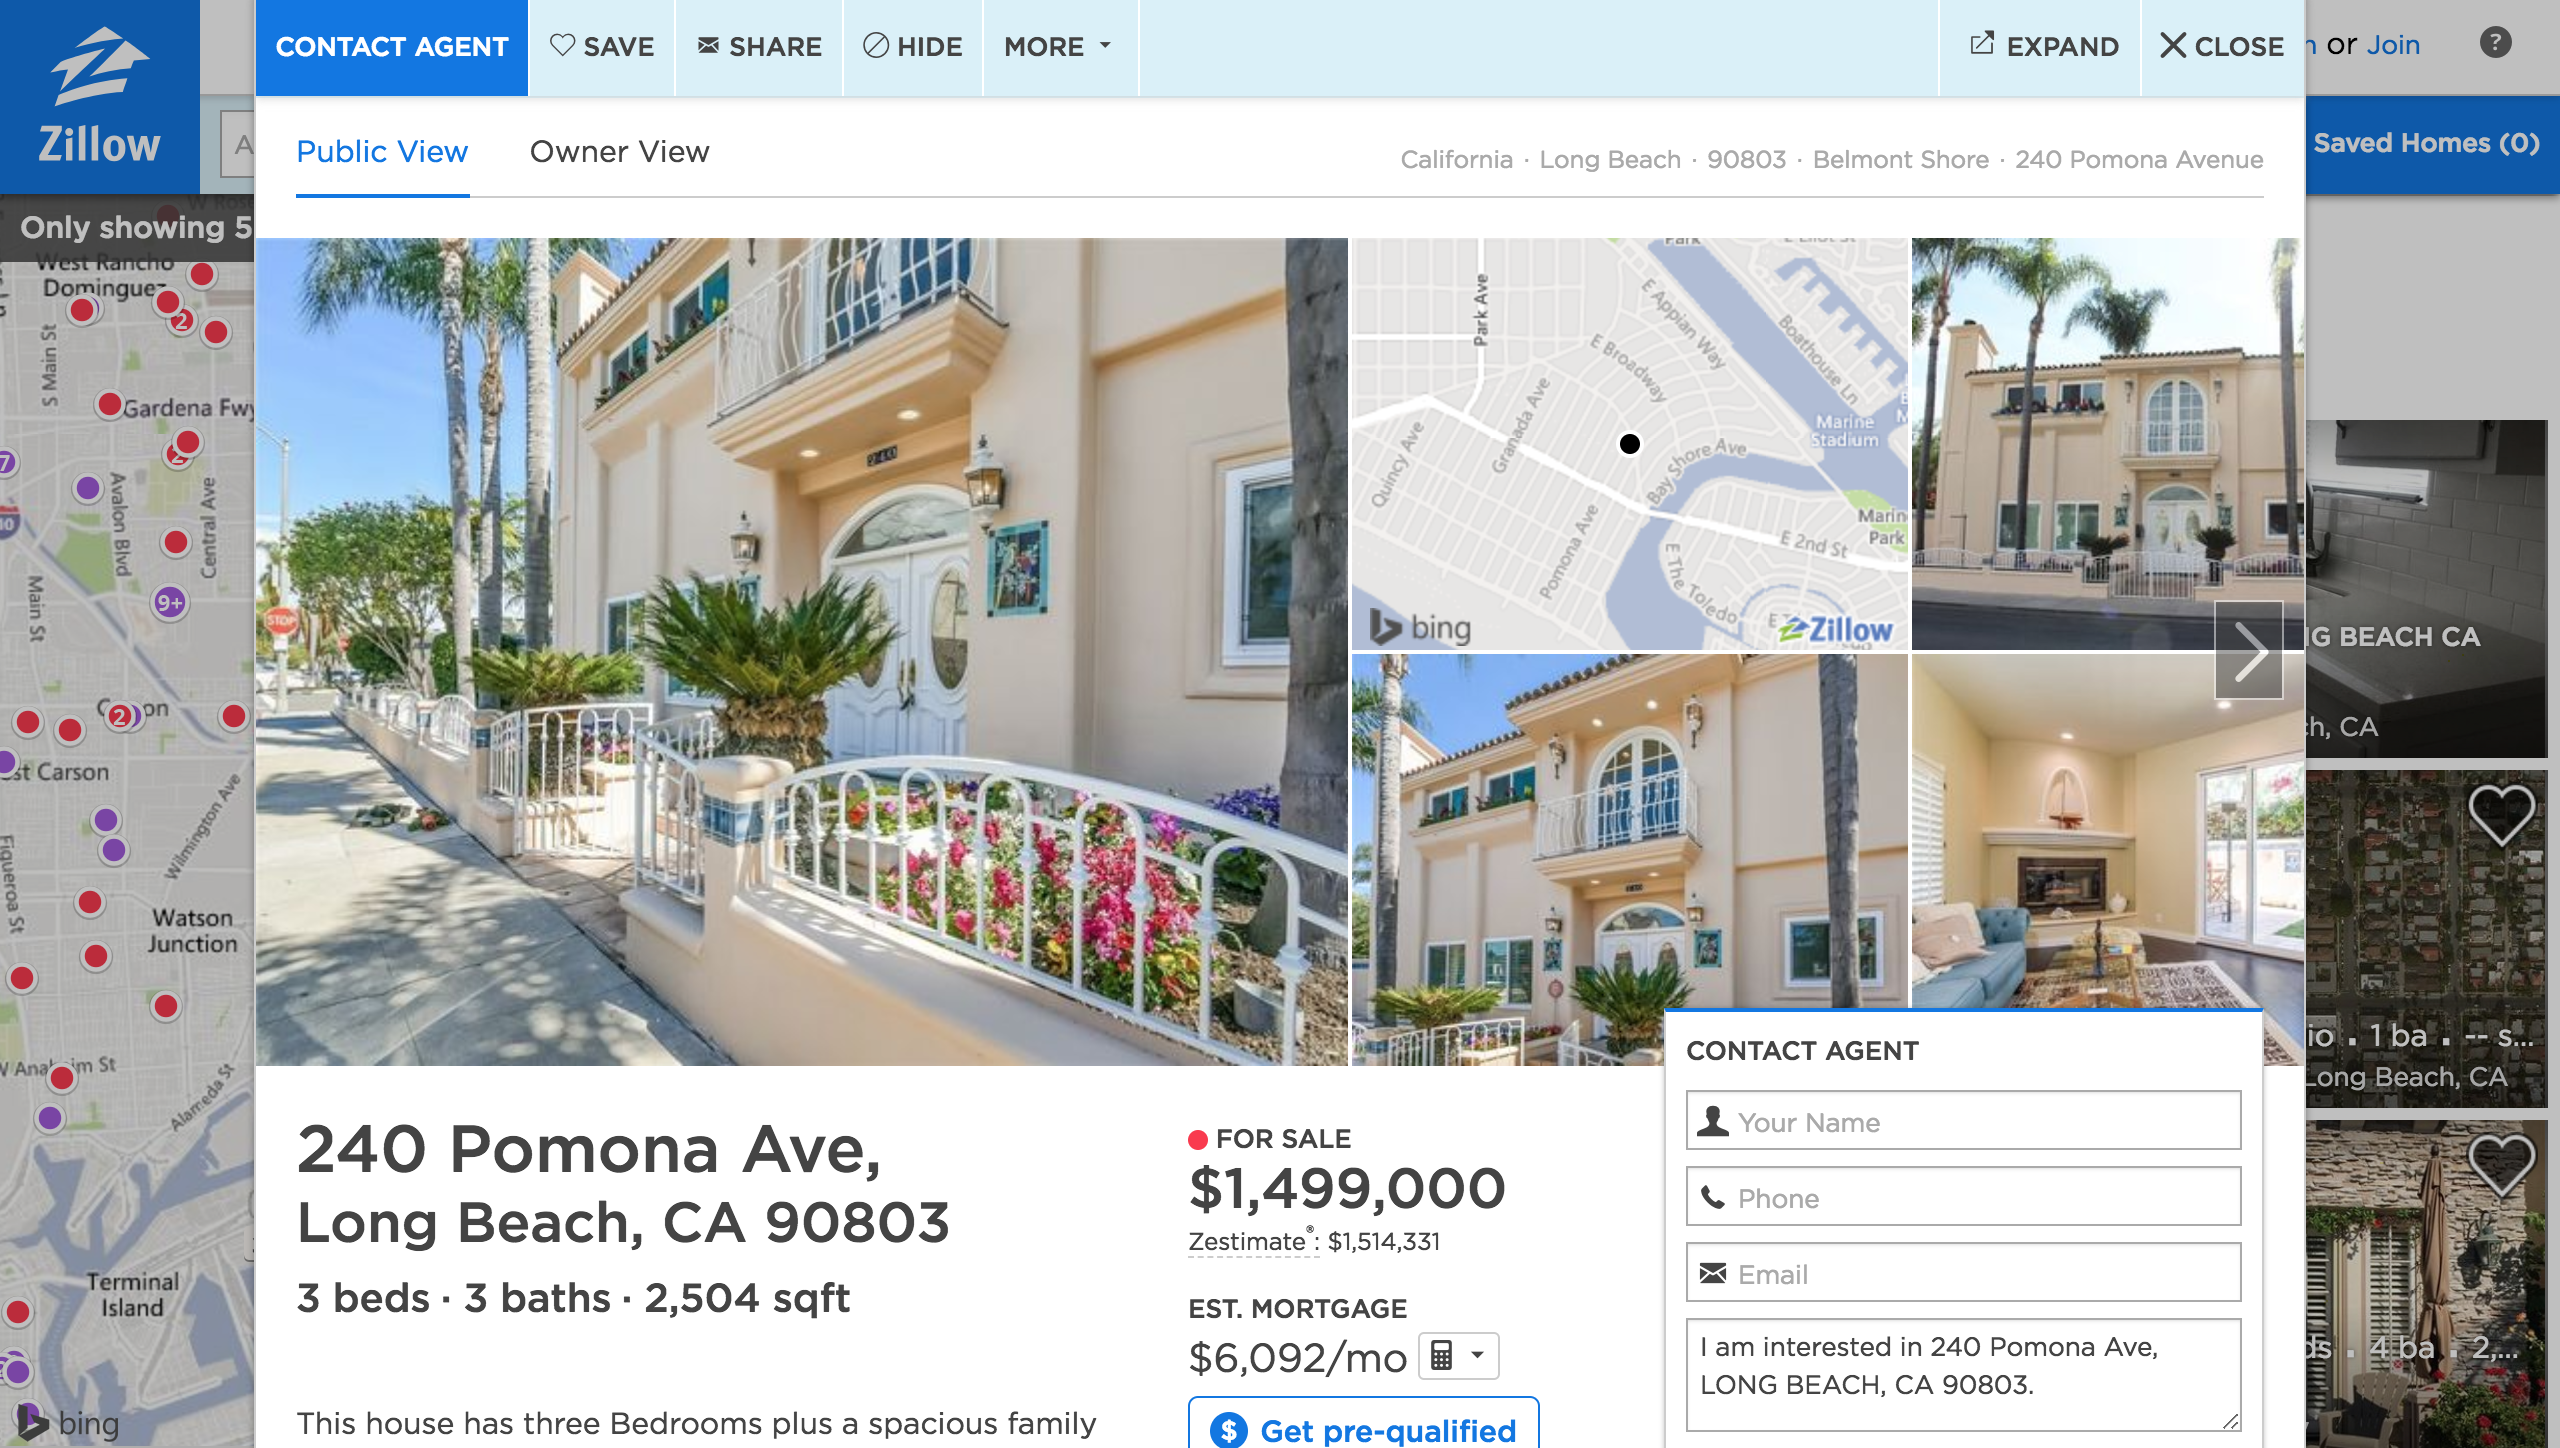

In [2]:
Image(filename='zillow.png', width=700)

## Data descriptions


    - properties_2016.csv : all the properties with their home features for 2016.
    
    - train_2016.csv : the training set with transactions from 1/1/2016 to 12/31/2016
    
    - sample_submission.csv : a sample submission file in the correct format
    
    - zillow_data_dictionary.xlsx : Data fields

## Load Dataset

    Traning Data는 2016년 동안 팔린 90275개의 집에 대한 log error 와 transaction dates 정보를 가짐
    
    logerror=log(Zestimate)−log(SalePrice)

In [3]:
# training data

train_16= pd.read_csv("~/src/train_2016.csv")
train_16.tail()

parcelid  logerror transactiondate
90270  10774160   -0.0356      2016-12-30
90271  12046695    0.0070      2016-12-30
90272  12995401   -0.2679      2016-12-30
90273  11402105    0.0602      2016-12-30
90274  12566293    0.4207      2016-12-30

In [4]:
# property data : 약 300만개의 집의 58개의 다른 특징 정보들을 가짐

properties_16 = pd.read_csv("~/src/properties_2016.csv")
properties_16.head()

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  10754147                    NaN                       NaN           NaN   
1  10759547                    NaN                       NaN           NaN   
2  10843547                    NaN                       NaN           NaN   
3  10859147                    NaN                       NaN           NaN   
4  10879947                    NaN                       NaN           NaN   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0          0.0         0.0                  NaN                    NaN   
1          0.0         0.0                  NaN                    NaN   
2          0.0         0.0                  NaN                    NaN   
3          0.0         0.0                  3.0                    7.0   
4          0.0         0.0                  4.0                    NaN   

   calculatedbathnbr  decktypeid         ...           numberofstories  \
0                NaN         NaN         ...                       NaN   
1                NaN         NaN         ...                       NaN   
2                NaN         NaN         ...                       NaN   
3                NaN         NaN         ...                       1.0   
4                NaN         NaN         ...                       NaN   

   fireplaceflag  structuretaxvaluedollarcnt  taxvaluedollarcnt  \
0            NaN                         NaN                9.0   
1            NaN                         NaN            27516.0   
2            NaN                    650756.0          1413387.0   
3            NaN                    571346.0          1156834.0   
4            NaN                    193796.0           433491.0   

   assessmentyear  landtaxvaluedollarcnt  taxamount  taxdelinquencyflag  \
0          2015.0                    9.0        NaN                 NaN   
1          2015.0                27516.0        NaN                 NaN   
2          2015.0               762631.0   20800.37                 NaN   
3          2015.0               585488.0   14557.57                 NaN   
4          2015.0               239695.0    5725.17                 NaN   

   taxdelinquencyyear  censustractandblock  
0                 NaN                  NaN  
1                 NaN                  NaN  
2                 NaN                  NaN  
3                 NaN                  NaN  
4                 NaN                  NaN  

[5 rows x 58 columns]

In [5]:
# train data, property data를 합친 dataset 만들기

df = pd.merge(train_16, properties_16)
df.tail()

parcelid  logerror transactiondate  airconditioningtypeid  \
90270  10774160   -0.0356      2016-12-30                    1.0   
90271  12046695    0.0070      2016-12-30                    NaN   
90272  12995401   -0.2679      2016-12-30                    NaN   
90273  11402105    0.0602      2016-12-30                    NaN   
90274  12566293    0.4207      2016-12-30                    NaN   

       architecturalstyletypeid  basementsqft  bathroomcnt  bedroomcnt  \
90270                       NaN           NaN          1.0         1.0   
90271                       NaN           NaN          3.0         3.0   
90272                       NaN           NaN          2.0         4.0   
90273                       NaN           NaN          2.0         2.0   
90274                       NaN           NaN          1.0         3.0   

       buildingclasstypeid  buildingqualitytypeid         ...           \
90270                  NaN                    4.0         ...            
90271                  NaN                    4.0         ...            
90272                  NaN                    7.0         ...            
90273                  NaN                    4.0         ...            
90274                  NaN                    7.0         ...            

       numberofstories  fireplaceflag  structuretaxvaluedollarcnt  \
90270              NaN            NaN                     43800.0   
90271              NaN            NaN                    117893.0   
90272              NaN            NaN                     22008.0   
90273              NaN            NaN                    132991.0   
90274              NaN            NaN                     66258.0   

       taxvaluedollarcnt  assessmentyear  landtaxvaluedollarcnt  taxamount  \
90270           191000.0          2015.0               147200.0    2495.24   
90271           161111.0          2015.0                43218.0    1886.54   
90272            38096.0          2015.0                16088.0    1925.70   
90273           165869.0          2015.0                32878.0    2285.57   
90274           163037.0          2015.0                96779.0    2560.96   

       taxdelinquencyflag  taxdelinquencyyear  censustractandblock  
90270                 NaN                 NaN         6.037132e+13  
90271                 NaN                 NaN         6.037301e+13  
90272                   Y                14.0         6.037433e+13  
90273                 NaN                 NaN         6.037601e+13  
90274                 NaN                 NaN         6.037544e+13  

[5 rows x 60 columns]

# 1. EDA
- - -

##### 종속 변수 파악하기

In [6]:
logerror_df = train_16.iloc[:, 1:2]
logerror_df.tail()

logerror
90270   -0.0356
90271    0.0070
90272   -0.2679
90273    0.0602
90274    0.4207

In [7]:
# 종속 변수의 특징값 파악하기

logerror_df.describe()

logerror
count  90275.000000
mean       0.011457
std        0.161079
min       -4.605000
25%       -0.025300
50%        0.006000
75%        0.039200
max        4.737000

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


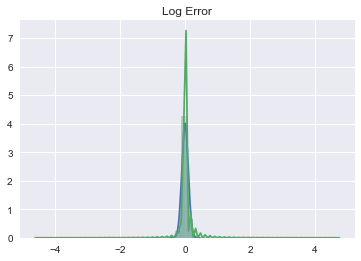

In [8]:
# 종속 변수의 분포 파악하기

y = logerror_df
np.random.seed(0)
N = 90274
x = sp.stats.norm(0, 0.1).rvs(N)

plt.title('Log Error')
sns.distplot(x)
sns.distplot(y)
plt.show()

In [9]:
figsize(10, 10)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


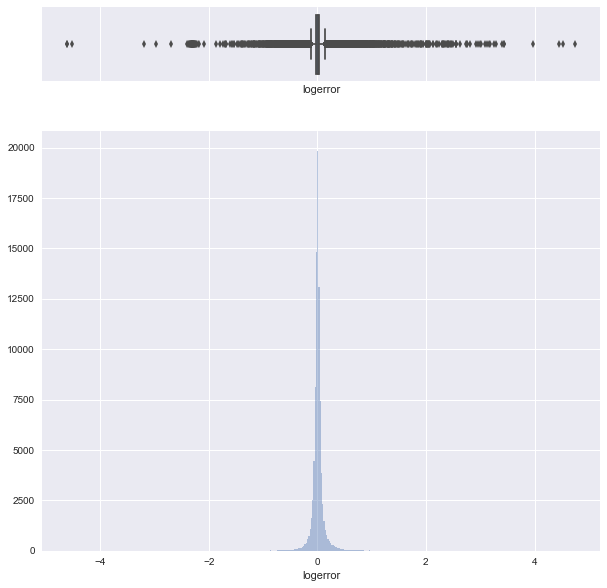

In [10]:
x = df['logerror']
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True ,
                                    gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist, bins=400, kde=False)
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
# plt.xlim([-0.3, 0.3])
plt.show()

##### 종속 변수와 위치 데이터(lat, lng) 간 관계 파악하기

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 576x576 with 0 Axes>

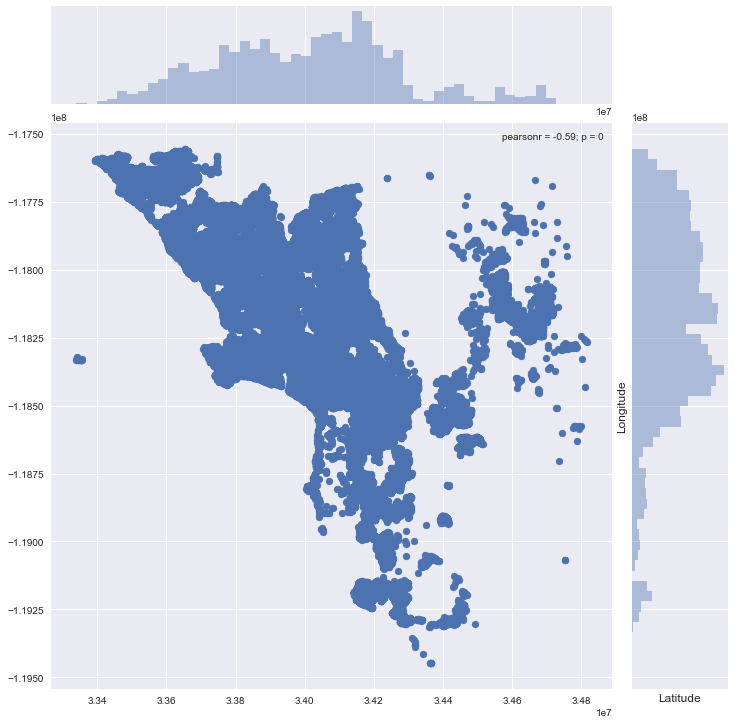

In [11]:
# lat, lng 데이터 구현하기

plt.figure(figsize=(8,8))
sns.jointplot(x=df.latitude.values, y=df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

In [12]:
geom_point()

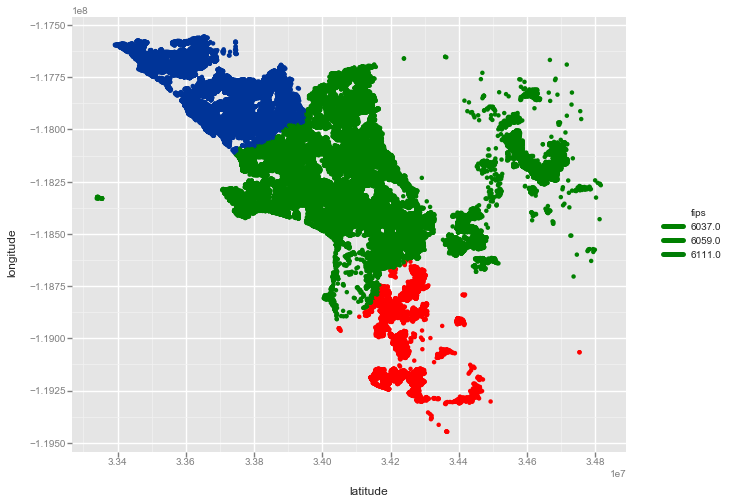

<ggplot: (-9223372036560591847)>

In [13]:
# fips

ggplot(aes(x='latitude', y='longitude', color='fips'), data=df) + geom_point() + \
scale_color_gradient(low='green', mid='blue', high='red')

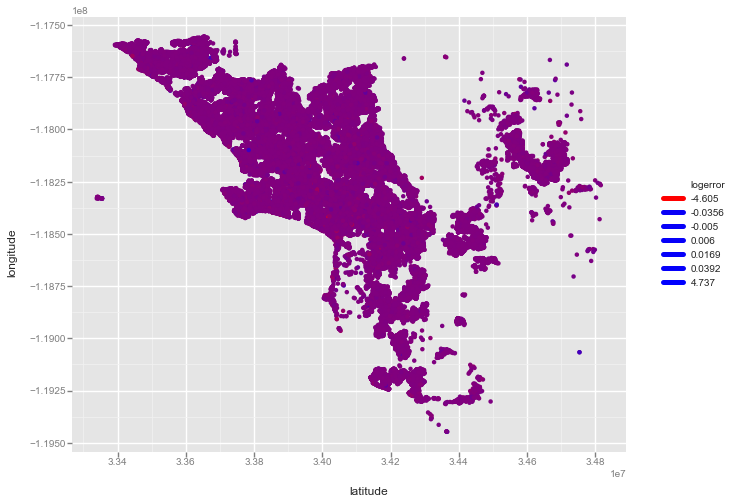

<ggplot: (294184070)>

In [14]:
# logerror

ggplot(aes(x='latitude', y='longitude', color='logerror'), data=df) + geom_point() \
+ scale_color_gradient(low = 'red', high = 'blue')

##### 종속 변수와 시간 데이터(transactiondate) 간 관계 파악하기

In [15]:
df['transactiondate'].dtypes

dtype('O')

In [16]:
month = df['transactiondate'].astype('datetime64').dt.month

/usr/local/lib/python3.6/site-packages/pandas/core/internals.py:3462: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


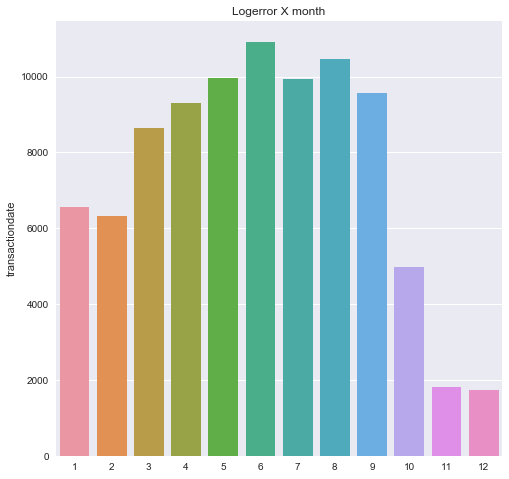

In [17]:
# 월 별 logerror data 빈도수

plt.figure(figsize=(8,8))
month_count = month.value_counts()

plt.title("Logerror X month")
sns.barplot(month_count.index, month_count)
plt.show()

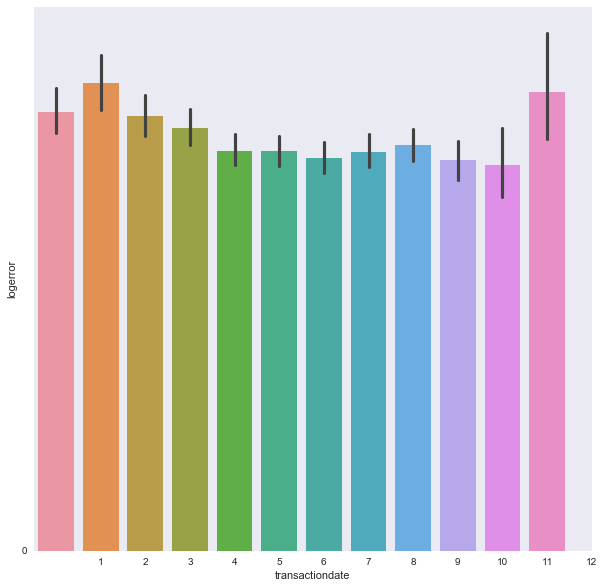

In [18]:
# 월 별 logerror 절대값 차이 (barplot)

plt.figure(figsize=(10,10))
sns.barplot(month, abs(df["logerror"]))
plt.xticks(np.arange(1,13))
plt.yticks(np.arange(0,1))
plt.show()

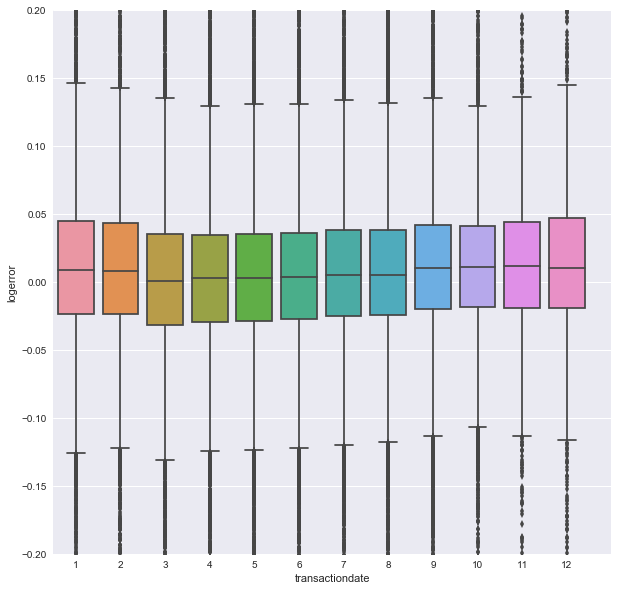

In [19]:
# 월 별 logerror 분포 차이 (boxplot)

plt.figure(figsize=(10,10))
sns.boxplot(month, df["logerror"])
plt.xticks(np.arange(0,13))
plt.ylim([-0.2,0.2])
plt.show()

##### 모든 변수의 데이터 타입 확인하기

- data type
- numeric, categorical
- int, float

In [20]:
# dtype

properties_16.dtypes

parcelid                          int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object
heatingorsystemtypeid           float64
latitude                        float64


In [21]:
# object feature 파악하기

feature_object = ['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']
object_df = properties_16[feature_object]

for feature in feature_object:
    print(object_df[feature].value_counts())

True    69014
Name: hashottuborspa, dtype: int64
0100    1153896
122      522145
0101     247494
010C     225410
1111     126491
34       123249
0200     104612
010D      60503
1         60167
010E      50978
1110      38363
0300      35926
0400      32821
1129      31391
070P      23763
0104      13988
1210      10356
1118       9677
0          9501
1128       9421
73         8570
012C       8172
01DC       6407
96         5684
38         4954
71         4117
0103       3501
1200       3299
0109       3165
010V       3019
         ...   
1002          1
0711          1
1723          1
0132          1
2003          1
07M           1
0450          1
02G0          1
8830          1
0122          1
7842          1
1820          1
0310          1
070M          1
7301          1
4400          1
0305          1
030B          1
0231          1
172G          1
3414          1
070G          1
030L          1
0141          1
020A          1
1205          1
5011          1
9100          1
0403   

In [22]:
object_df.describe()

hashottuborspa propertycountylandusecode propertyzoningdesc  \
count           69014                   2972940            1978629   
unique              1                       240               5638   
top              True                      0100               LAR1   
freq            69014                   1153896             275029   

       fireplaceflag taxdelinquencyflag  
count           5163              56462  
unique             1                  1  
top             True                  Y  
freq            5163              56462

In [23]:
properties_16.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

In [24]:
# object feature 외 다른 feature의 dtypes 확인하기

non_object = ['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'taxdelinquencyyear',
       'censustractandblock']
non_object

['parcelid',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landt

In [25]:
non_object_df = properties_16[non_object]
non_object_df.tail()

parcelid  airconditioningtypeid  architecturalstyletypeid  \
2985212  168176230                    NaN                       NaN   
2985213   14273630                    NaN                       NaN   
2985214  168040630                    NaN                       NaN   
2985215  168040830                    NaN                       NaN   
2985216  168040430                    NaN                       NaN   

         basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
2985212           NaN          NaN         NaN                  NaN   
2985213           NaN          NaN         NaN                  NaN   
2985214           NaN          NaN         NaN                  NaN   
2985215           NaN          NaN         NaN                  NaN   
2985216           NaN          NaN         NaN                  NaN   

         buildingqualitytypeid  calculatedbathnbr  decktypeid  \
2985212                    NaN                NaN         NaN   
2985213                    NaN                NaN         NaN   
2985214                    NaN                NaN         NaN   
2985215                    NaN                NaN         NaN   
2985216                    NaN                NaN         NaN   

                ...           yardbuildingsqft26  yearbuilt  numberofstories  \
2985212         ...                          NaN        NaN              NaN   
2985213         ...                          NaN        NaN              NaN   
2985214         ...                          NaN        NaN              NaN   
2985215         ...                          NaN        NaN              NaN   
2985216         ...                          NaN        NaN              NaN   

         structuretaxvaluedollarcnt  taxvaluedollarcnt  assessmentyear  \
2985212                         NaN                NaN             NaN   
2985213                         NaN                NaN             NaN   
2985214                         NaN                NaN             NaN   
2985215                         NaN                NaN             NaN   
2985216                         NaN                NaN             NaN   

         landtaxvaluedollarcnt  taxamount  taxdelinquencyyear  \
2985212                    NaN        NaN                 NaN   
2985213                    NaN        NaN                 NaN   
2985214                    NaN        NaN                 NaN   
2985215                    NaN        NaN                 NaN   
2985216                    NaN        NaN                 NaN   

         censustractandblock  
2985212                  NaN  
2985213                  NaN  
2985214                  NaN  
2985215                  NaN  
2985216                  NaN  

[5 rows x 53 columns]

In [26]:
# non_object feature의 dtype, 특징값 파악하기

In [27]:
# 1. ~15

for feature in non_object[:15]:
    print(non_object_df[feature].value_counts())

12584959    1
12755709    1
12751611    1
12753658    1
12747513    1
12749560    1
12776183    1
12778230    1
12772085    1
12774132    1
12767987    1
12770034    1
12763889    1
12729070    1
12722925    1
12724972    1
12718827    1
12720874    1
12714729    1
12743399    1
12745446    1
12757756    1
12761854    1
12741348    1
12759807    1
14016022    1
12820200    1
12427380    1
17066269    1
11446598    1
           ..
10861026    1
10854881    1
10856928    1
10768863    1
10770910    1
10764765    1
10766812    1
10824176    1
10828274    1
10826227    1
10834431    1
12253706    1
12247561    1
12227079    1
12222981    1
12225028    1
12237314    1
12231169    1
12233216    1
10836478    1
10815988    1
10830333    1
10832380    1
10842619    1
10844666    1
10838521    1
10840568    1
10820086    1
10813941    1
12582912    1
Name: parcelid, Length: 2985217, dtype: int64
1.0     742364
13.0     58457
5.0       8795
11.0      1818
12.0        59
9.0         19
3.0       

In [28]:
non_object_df.iloc[:, :15].describe()

parcelid  airconditioningtypeid  architecturalstyletypeid  \
count  2.985217e+06          811519.000000               6061.000000   
mean   1.332586e+07               1.931166                  7.202607   
std    7.909966e+06               3.148587                  2.436290   
min    1.071172e+07               1.000000                  2.000000   
25%    1.164371e+07               1.000000                  7.000000   
50%    1.254509e+07               1.000000                  7.000000   
75%    1.409712e+07               1.000000                  7.000000   
max    1.696019e+08              13.000000                 27.000000   

       basementsqft   bathroomcnt    bedroomcnt  buildingclasstypeid  \
count   1628.000000  2.973755e+06  2.973767e+06         12629.000000   
mean     646.883292  2.209143e+00  3.088949e+00             3.725948   
std      538.793473  1.077754e+00  1.275859e+00             0.501700   
min       20.000000  0.000000e+00  0.000000e+00             1.000000   
25%      272.000000  2.000000e+00  2.000000e+00             3.000000   
50%      534.000000  2.000000e+00  3.000000e+00             4.000000   
75%      847.250000  3.000000e+00  4.000000e+00             4.000000   
max     8516.000000  2.000000e+01  2.000000e+01             5.000000   

       buildingqualitytypeid  calculatedbathnbr  decktypeid  \
count           1.938488e+06       2.856305e+06     17096.0   
mean            5.784787e+00       2.299263e+00        66.0   
std             1.805352e+00       1.000736e+00         0.0   
min             1.000000e+00       1.000000e+00        66.0   
25%             4.000000e+00       2.000000e+00        66.0   
50%             7.000000e+00       2.000000e+00        66.0   
75%             7.000000e+00       3.000000e+00        66.0   
max             1.200000e+01       2.000000e+01        66.0   

       finishedfloor1squarefeet  calculatedfinishedsquarefeet  \
count             202717.000000                  2.929652e+06   
mean                1380.630396                  1.827162e+03   
std                  632.868543                  1.819780e+03   
min                    3.000000                  1.000000e+00   
25%                 1012.000000                  1.213000e+03   
50%                 1283.000000                  1.572000e+03   
75%                 1615.000000                  2.136000e+03   
max                31303.000000                  9.525760e+05   

       finishedsquarefeet12  finishedsquarefeet13  finishedsquarefeet15  
count          2.709184e+06           7672.000000         190798.000000  
mean           1.760001e+03           1178.900678           2739.187235  
std            9.710610e+02            357.073036           5447.428327  
min            1.000000e+00            120.000000            112.000000  
25%            1.196000e+03            960.000000           1694.000000  
50%            1.539000e+03           1296.000000           2172.000000  
75%            2.070000e+03           1440.000000           2976.000000  
max            2.903450e+05           2688.000000         820242.000000

In [29]:
# 2. 15~30

for feature in non_object[15:30]:
    print(non_object_df[feature].value_counts())

1252.0    923
1233.0    864
1120.0    705
1226.0    616
1612.0    597
1244.0    592
798.0     579
1441.0    578
1205.0    578
1260.0    565
441.0     556
1431.0    547
1058.0    542
979.0     528
1227.0    524
1308.0    507
725.0     500
1110.0    498
880.0     495
1040.0    483
1020.0    482
1218.0    474
960.0     465
1462.0    451
1407.0    437
817.0     435
1070.0    434
1108.0    428
944.0     428
1498.0    426
         ... 
4843.0      1
4830.0      1
4919.0      1
4828.0      1
3573.0      1
4817.0      1
4811.0      1
4809.0      1
4808.0      1
4806.0      1
4858.0      1
3562.0      1
4862.0      1
4865.0      1
3539.0      1
4917.0      1
4905.0      1
4903.0      1
3546.0      1
4896.0      1
4894.0      1
4893.0      1
4892.0      1
4886.0      1
4882.0      1
3551.0      1
4874.0      1
4872.0      1
4868.0      1
4065.0      1
Name: finishedsquarefeet50, Length: 4802, dtype: int64
952.0     101
800.0      90
3820.0     88
720.0      74
600.0      68
3600.0     62
906.0  

1.0    36939
Name: pooltypeid10, dtype: int64
1.0    32075
Name: pooltypeid2, dtype: int64


In [30]:
non_object_df.iloc[:, 15:30].describe()

finishedsquarefeet50  finishedsquarefeet6          fips   fireplacecnt  \
count         202717.000000         22001.000000  2.973780e+06  312637.000000   
mean            1388.944578          2414.339439  6.048032e+03       1.168710   
std              664.488709          7695.302952  2.023278e+01       0.461273   
min                3.000000           117.000000  6.037000e+03       1.000000   
25%             1013.000000          1079.000000  6.037000e+03       1.000000   
50%             1284.000000          1992.000000  6.037000e+03       1.000000   
75%             1618.000000          3366.000000  6.059000e+03       1.000000   
max            31303.000000        952576.000000  6.111000e+03       9.000000   

        fullbathcnt   garagecarcnt  garagetotalsqft  heatingorsystemtypeid  \
count  2.856305e+06  883267.000000    883267.000000           1.806401e+06   
mean   2.244165e+00       1.823517       383.769357           4.012053e+00   
std    9.912054e-01       0.610035       245.443419           3.293733e+00   
min    1.000000e+00       0.000000         0.000000           1.000000e+00   
25%    2.000000e+00       2.000000       324.000000           2.000000e+00   
50%    2.000000e+00       2.000000       441.000000           2.000000e+00   
75%    3.000000e+00       2.000000       494.000000           7.000000e+00   
max    2.000000e+01      25.000000      7749.000000           2.400000e+01   

           latitude     longitude  lotsizesquarefeet   poolcnt   poolsizesum  \
count  2.973780e+06  2.973780e+06       2.709118e+06  517534.0  27960.000000   
mean   3.400147e+07 -1.182019e+08       2.282281e+04       1.0    519.710980   
std    2.433812e+05  3.453171e+05       3.375924e+05       0.0    191.323284   
min    3.332439e+07 -1.194758e+08       1.000000e+02       1.0     19.000000   
25%    3.382768e+07 -1.183930e+08       5.688000e+03       1.0    430.000000   
50%    3.400825e+07 -1.181725e+08       7.000000e+03       1.0    495.000000   
75%    3.416186e+07 -1.179495e+08       9.898000e+03       1.0    594.000000   
max    3.481965e+07 -1.175543e+08       3.282638e+08       1.0  17410.000000   

       pooltypeid10  pooltypeid2  
count       36939.0      32075.0  
mean            1.0          1.0  
std             0.0          0.0  
min             1.0          1.0  
25%             1.0          1.0  
50%             1.0          1.0  
75%             1.0          1.0  
max             1.0          1.0

In [31]:
# 3. 30~45

for feature in non_object[30:45]:
    print(non_object_df[feature].value_counts())

1.0    485459
Name: pooltypeid7, dtype: int64
261.0    2148362
266.0     481067
246.0     114888
269.0      61469
263.0      58438
248.0      40325
247.0      40022
31.0        9462
265.0       9421
47.0        4314
260.0       2754
267.0       1817
275.0       1201
264.0        204
270.0         36
Name: propertylandusetypeid, dtype: int64
6.059052e+07    1518
6.037920e+07    1455
6.059063e+07     895
6.037137e+07     886
6.037577e+07     825
6.037920e+07     816
6.037274e+07     812
6.037277e+07     800
6.059063e+07     793
6.059052e+07     790
6.111007e+07     771
6.037920e+07     756
6.059052e+07     754
6.037208e+07     749
6.059053e+07     719
6.037142e+07     654
6.037275e+07     639
6.059022e+07     632
6.111008e+07     631
6.037236e+07     629
6.037262e+07     612
6.037261e+07     607
6.037544e+07     598
6.037113e+07     595
6.059075e+07     594
6.037140e+07     587
6.059074e+07     584
6.059032e+07     580
6.059032e+07     572
6.037578e+07     568
                ... 
6.1110

1955.0    88586
1950.0    76142
1954.0    73307
1953.0    67085
1956.0    65736
1964.0    64929
1951.0    56686
1963.0    54593
1952.0    54405
1947.0    53006
1948.0    52711
1989.0    52520
1973.0    51464
1965.0    49489
1962.0    48494
1949.0    48271
1979.0    47514
1959.0    47224
1977.0    46663
1957.0    46526
1987.0    44851
1972.0    44434
1971.0    43022
1978.0    42673
1960.0    41931
1976.0    41782
1980.0    41392
1990.0    41200
1961.0    40205
1986.0    38548
          ...  
1870.0        5
1801.0        3
1876.0        2
1874.0        2
1806.0        2
1808.0        2
1815.0        2
1819.0        2
1865.0        2
1878.0        2
1855.0        2
1862.0        2
1859.0        2
1853.0        1
1821.0        1
1805.0        1
1877.0        1
1807.0        1
1810.0        1
1879.0        1
1823.0        1
1840.0        1
1824.0        1
1825.0        1
1828.0        1
1829.0        1
1831.0        1
1833.0        1
1834.0        1
1827.0        1
Name: yearbuilt, Length:

In [32]:
non_object_df.iloc[:, 30:45].describe()

pooltypeid7  propertylandusetypeid  rawcensustractandblock  \
count     485459.0           2.973780e+06            2.973780e+06   
mean           1.0           2.600484e+02            6.048345e+07   
std            0.0           1.590817e+01            2.008117e+05   
min            1.0           3.100000e+01            6.037101e+07   
25%            1.0           2.610000e+02            6.037320e+07   
50%            1.0           2.610000e+02            6.037571e+07   
75%            1.0           2.610000e+02            6.059042e+07   
max            1.0           2.750000e+02            6.111009e+07   

       regionidcity  regionidcounty  regionidneighborhood   regionidzip  \
count  2.922372e+06    2.973780e+06          1.156402e+06  2.971237e+06   
mean   3.499335e+04    2.570461e+03          1.934764e+05  9.655267e+04   
std    5.072747e+04    7.880711e+02          1.657133e+05  3.673175e+03   
min    3.491000e+03    1.286000e+03          6.952000e+03  9.598200e+04   
25%    1.244700e+04    2.061000e+03          4.673600e+04  9.618000e+04   
50%    2.521800e+04    3.101000e+03          1.189200e+05  9.637700e+04   
75%    4.545700e+04    3.101000e+03          2.748000e+05  9.697400e+04   
max    3.965560e+05    3.101000e+03          7.641670e+05  3.996750e+05   

            roomcnt  storytypeid  threequarterbathnbr  typeconstructiontypeid  \
count  2.973742e+06       1624.0        311631.000000             6747.000000   
mean   1.475018e+00          7.0             1.010009                5.999555   
std    2.840403e+00          0.0             0.117709                0.384050   
min    0.000000e+00          7.0             1.000000                4.000000   
25%    0.000000e+00          7.0             1.000000                6.000000   
50%    0.000000e+00          7.0             1.000000                6.000000   
75%    0.000000e+00          7.0             1.000000                6.000000   
max    9.600000e+01          7.0             7.000000               13.000000   

            unitcnt  yardbuildingsqft17  yardbuildingsqft26     yearbuilt  
count  1.977490e+06        80355.000000         2647.000000  2.925289e+06  
mean   1.181171e+00          319.803397          278.296562  1.964262e+03  
std    2.447896e+00          233.086314          369.731508  2.344132e+01  
min    1.000000e+00           10.000000           10.000000  1.801000e+03  
25%    1.000000e+00          190.000000           96.000000  1.950000e+03  
50%    1.000000e+00          270.000000          168.000000  1.963000e+03  
75%    1.000000e+00          390.000000          320.000000  1.981000e+03  
max    9.970000e+02         7983.000000         6141.000000  2.015000e+03

In [33]:
# 4. 45~

for feature in non_object[45:]:
    print(non_object_df[feature].value_counts())

1.0     424186
2.0     242125
3.0      15678
4.0         58
5.0         11
6.0          4
7.0          2
41.0         1
20.0         1
17.0         1
14.0         1
8.0          1
Name: numberofstories, dtype: int64
100000.0    1880
102461.0    1578
104510.0    1513
200000.0    1418
107401.0    1411
101998.0    1388
150000.0    1378
106600.0    1316
90000.0     1289
203996.0    1246
140000.0    1234
120000.0    1178
110000.0    1171
80000.0     1127
95000.0     1083
130000.0    1081
204922.0    1080
75000.0     1071
125000.0    1057
92000.0     1044
94000.0     1043
105000.0    1039
115000.0    1030
84000.0     1020
160000.0    1002
96000.0     1000
91000.0      994
89000.0      990
85000.0      989
87000.0      989
            ... 
828870.0       1
350999.0       1
828780.0       1
351059.0       1
351063.0       1
351068.0       1
351137.0       1
351135.0       1
351134.0       1
828727.0       1
351129.0       1
351128.0       1
351125.0       1
351123.0       1
351118.0       1
35

In [34]:
non_object_df.iloc[:, 45:].describe()

numberofstories  structuretaxvaluedollarcnt  taxvaluedollarcnt  \
count    682069.000000                2.930235e+06       2.942667e+06   
mean          1.401464                1.708836e+05       4.204790e+05   
std           0.539076                4.020683e+05       7.263467e+05   
min           1.000000                1.000000e+00       1.000000e+00   
25%           1.000000                7.480000e+04       1.796750e+05   
50%           1.000000                1.225900e+05       3.060860e+05   
75%           2.000000                1.968890e+05       4.880000e+05   
max          41.000000                2.514860e+08       2.827860e+08   

       assessmentyear  landtaxvaluedollarcnt     taxamount  \
count    2.973778e+06           2.917484e+06  2.953967e+06   
mean     2.014999e+03           2.524780e+05  5.377607e+03   
std      3.683161e-02           4.450132e+05  9.183107e+03   
min      2.000000e+03           1.000000e+00  1.340000e+00   
25%      2.015000e+03           7.483600e+04  2.461070e+03   
50%      2.015000e+03           1.670420e+05  3.991780e+03   
75%      2.015000e+03           3.069180e+05  6.201005e+03   
max      2.016000e+03           9.024622e+07  3.458861e+06   

       taxdelinquencyyear  censustractandblock  
count        56464.000000         2.910091e+06  
mean            13.892409         6.048431e+13  
std              2.581006         3.249035e+11  
min              0.000000        -1.000000e+00  
25%             14.000000         6.037400e+13  
50%             14.000000         6.037572e+13  
75%             15.000000         6.059042e+13  
max             99.000000         4.830301e+14

In [35]:
featurevalue_df = non_object_df.iloc[:, :].describe().T
featurevalue_df.to_csv('~/test.csv')

In [36]:
# numeric(cont) : parcelid, basementsqft, finishedfloor1squarefeet, calculatedfinishedsquarefeet, finishedsquarefeet12
# finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, finishedsquarefeet6, garagetotalsqft
# latitude, longitude, lotsizesquarefeet, poolsizesum, yardbuildingsqft17, yardbuildingsqft26, structuretaxvaluedollarcnt
# taxvaluedollarcnt, landtaxvaluedollarcnt, taxamount

# numeric(discrete) : bathroomcnt, bedroomcnt, buildingqualitytypeid, calculatedbathnbr, fireplacecnt, fullbathcnt
# garagecarcnt, roomcnt, threequarterbathnbr, unitcnt, numberofstories

# numeric(binary) : poolcnt, pooltypeid10, pooltypeid2, pooltypeid7,  decktypeid, storytypeid
# hashottuborspa, fireplaceflag, taxdelinquencyflag

# categorical(18) : airconditioningtypeid, architecturalstyletypeid, buildingclasstypeid, fips, heatingorsystemtypeid
# propertylandusetypeid, rawcensustractandblock, regionidcity, regionidcounty, regionidneighborhood, regionidzip
# typeconstructiontypeid, yearbuilt, assessmentyear, taxdelinquencyyear, censustractandblock1, propertycountylandusecode
# propertyzoningdesc

##### feature 분류하기

In [37]:
feature_num = ['parcelid', 'basementsqft', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 
                'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 
                'finishedsquarefeet6', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolsizesum',
                'yardbuildingsqft17', 'yardbuildingsqft26', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
                'landtaxvaluedollarcnt', 'taxamount', 'bathroomcnt', 'bedroomcnt',
               'calculatedbathnbr', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'roomcnt', 'threequarterbathnbr',
               'unitcnt', 'numberofstories', 'poolcnt']

feature_cat = ['pooltypeid10', 'pooltypeid2', 'pooltypeid7',  'decktypeid', 'storytypeid', 'hashottuborspa',
               'fireplaceflag', 'taxdelinquencyflag', 'airconditioningtypeid', 'architecturalstyletypeid', 'buildingqualitytypeid',
               'buildingclasstypeid', 'fips', 'heatingorsystemtypeid', 'propertylandusetypeid', 'rawcensustractandblock',
               'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'typeconstructiontypeid', 
               'yearbuilt', 'assessmentyear', 'taxdelinquencyyear', 'censustractandblock', 'propertycountylandusecode',
               'propertyzoningdesc']

print("numeric variable counts : ", len(feature_num))
print("categorical variable counts : ", len(feature_cat))


numeric variable counts :  31
categorical variable counts :  27


##### 독립변수들의 분포 파악하기(distplot)

In [38]:
# distplot 용 test_df 만들기

test_df = df.copy()
test_df.fillna(-1, inplace=True)
test_df.tail()

parcelid  logerror transactiondate  airconditioningtypeid  \
90270  10774160   -0.0356      2016-12-30                    1.0   
90271  12046695    0.0070      2016-12-30                   -1.0   
90272  12995401   -0.2679      2016-12-30                   -1.0   
90273  11402105    0.0602      2016-12-30                   -1.0   
90274  12566293    0.4207      2016-12-30                   -1.0   

       architecturalstyletypeid  basementsqft  bathroomcnt  bedroomcnt  \
90270                      -1.0          -1.0          1.0         1.0   
90271                      -1.0          -1.0          3.0         3.0   
90272                      -1.0          -1.0          2.0         4.0   
90273                      -1.0          -1.0          2.0         2.0   
90274                      -1.0          -1.0          1.0         3.0   

       buildingclasstypeid  buildingqualitytypeid         ...           \
90270                 -1.0                    4.0         ...            
90271                 -1.0                    4.0         ...            
90272                 -1.0                    7.0         ...            
90273                 -1.0                    4.0         ...            
90274                 -1.0                    7.0         ...            

       numberofstories  fireplaceflag  structuretaxvaluedollarcnt  \
90270             -1.0             -1                     43800.0   
90271             -1.0             -1                    117893.0   
90272             -1.0             -1                     22008.0   
90273             -1.0             -1                    132991.0   
90274             -1.0             -1                     66258.0   

       taxvaluedollarcnt  assessmentyear  landtaxvaluedollarcnt  taxamount  \
90270           191000.0          2015.0               147200.0    2495.24   
90271           161111.0          2015.0                43218.0    1886.54   
90272            38096.0          2015.0                16088.0    1925.70   
90273           165869.0          2015.0                32878.0    2285.57   
90274           163037.0          2015.0                96779.0    2560.96   

       taxdelinquencyflag  taxdelinquencyyear  censustractandblock  
90270                  -1                -1.0         6.037132e+13  
90271                  -1                -1.0         6.037301e+13  
90272                   Y                14.0         6.037433e+13  
90273                  -1                -1.0         6.037601e+13  
90274                  -1                -1.0         6.037544e+13  

[5 rows x 60 columns]

In [39]:
num_df = test_df[feature_num]
print(num_df.columns, len(num_df.columns))
num_df.tail()

Index(['parcelid', 'basementsqft', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'garagetotalsqft', 'latitude', 'longitude',
       'lotsizesquarefeet', 'poolsizesum', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'bathroomcnt', 'bedroomcnt',
       'calculatedbathnbr', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'numberofstories',
       'poolcnt'],
      dtype='object') 31


parcelid  basementsqft  finishedfloor1squarefeet  \
90270  10774160          -1.0                      -1.0   
90271  12046695          -1.0                      -1.0   
90272  12995401          -1.0                      -1.0   
90273  11402105          -1.0                      -1.0   
90274  12566293          -1.0                      -1.0   

       calculatedfinishedsquarefeet  finishedsquarefeet12  \
90270                         653.0                 653.0   
90271                        2856.0                2856.0   
90272                        2617.0                  -1.0   
90273                        1034.0                1034.0   
90274                        1524.0                1524.0   

       finishedsquarefeet13  finishedsquarefeet15  finishedsquarefeet50  \
90270                  -1.0                  -1.0                  -1.0   
90271                  -1.0                  -1.0                  -1.0   
90272                  -1.0                2617.0                  -1.0   
90273                  -1.0                  -1.0                  -1.0   
90274                  -1.0                  -1.0                  -1.0   

       finishedsquarefeet6  garagetotalsqft   ...     bedroomcnt  \
90270                 -1.0             -1.0   ...            1.0   
90271                 -1.0             -1.0   ...            3.0   
90272                 -1.0             -1.0   ...            4.0   
90273                 -1.0             -1.0   ...            2.0   
90274                 -1.0             -1.0   ...            3.0   

       calculatedbathnbr  fireplacecnt  fullbathcnt  garagecarcnt  roomcnt  \
90270                1.0          -1.0          1.0          -1.0      0.0   
90271                3.0          -1.0          3.0          -1.0      0.0   
90272                2.0          -1.0          2.0          -1.0      0.0   
90273                2.0          -1.0          2.0          -1.0      0.0   
90274                1.0          -1.0          1.0          -1.0      0.0   

       threequarterbathnbr  unitcnt  numberofstories  poolcnt  
90270                 -1.0      1.0             -1.0      1.0  
90271                 -1.0      1.0             -1.0     -1.0  
90272                 -1.0      2.0             -1.0     -1.0  
90273                 -1.0      1.0             -1.0     -1.0  
90274                 -1.0      1.0             -1.0     -1.0  

[5 rows x 31 columns]

In [40]:
cat_df = test_df[feature_cat]
print(cat_df.columns, len(cat_df.columns))
cat_df.tail()

Index(['pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'decktypeid',
       'storytypeid', 'hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag',
       'airconditioningtypeid', 'architecturalstyletypeid',
       'buildingqualitytypeid', 'buildingclasstypeid', 'fips',
       'heatingorsystemtypeid', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'typeconstructiontypeid',
       'yearbuilt', 'assessmentyear', 'taxdelinquencyyear',
       'censustractandblock', 'propertycountylandusecode',
       'propertyzoningdesc'],
      dtype='object') 27


pooltypeid10  pooltypeid2  pooltypeid7  decktypeid  storytypeid  \
90270          -1.0         -1.0          1.0        -1.0         -1.0   
90271          -1.0         -1.0         -1.0        -1.0         -1.0   
90272          -1.0         -1.0         -1.0        -1.0         -1.0   
90273          -1.0         -1.0         -1.0        -1.0         -1.0   
90274          -1.0         -1.0         -1.0        -1.0         -1.0   

      hashottuborspa fireplaceflag taxdelinquencyflag  airconditioningtypeid  \
90270             -1            -1                 -1                    1.0   
90271             -1            -1                 -1                   -1.0   
90272             -1            -1                  Y                   -1.0   
90273             -1            -1                 -1                   -1.0   
90274             -1            -1                 -1                   -1.0   

       architecturalstyletypeid         ...          regionidcounty  \
90270                      -1.0         ...                  3101.0   
90271                      -1.0         ...                  3101.0   
90272                      -1.0         ...                  3101.0   
90273                      -1.0         ...                  3101.0   
90274                      -1.0         ...                  3101.0   

       regionidneighborhood  regionidzip  typeconstructiontypeid  yearbuilt  \
90270               40548.0      96364.0                    -1.0     1979.0   
90271              274580.0      96327.0                    -1.0     1965.0   
90272                  -1.0      96478.0                    -1.0     1924.0   
90273                  -1.0      96133.0                    -1.0     1981.0   
90274                  -1.0      96244.0                    -1.0     1947.0   

       assessmentyear  taxdelinquencyyear  censustractandblock  \
90270          2015.0                -1.0         6.037132e+13   
90271          2015.0                -1.0         6.037301e+13   
90272          2015.0                14.0         6.037433e+13   
90273          2015.0                -1.0         6.037601e+13   
90274          2015.0                -1.0         6.037544e+13   

       propertycountylandusecode  propertyzoningdesc  
90270                       010C             LARD1.5  
90271                       0100              GLR1RY  
90272                       0200              EMR3YY  
90273                       010C               INR4*  
90274                       0100               CARS*  

[5 rows x 27 columns]

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


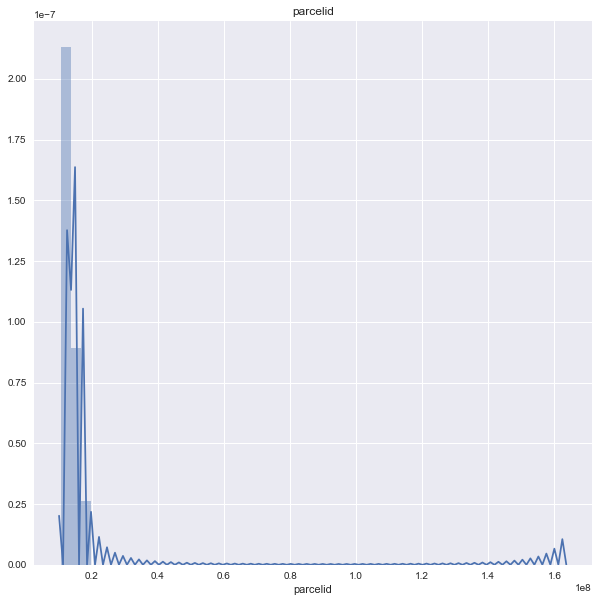

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


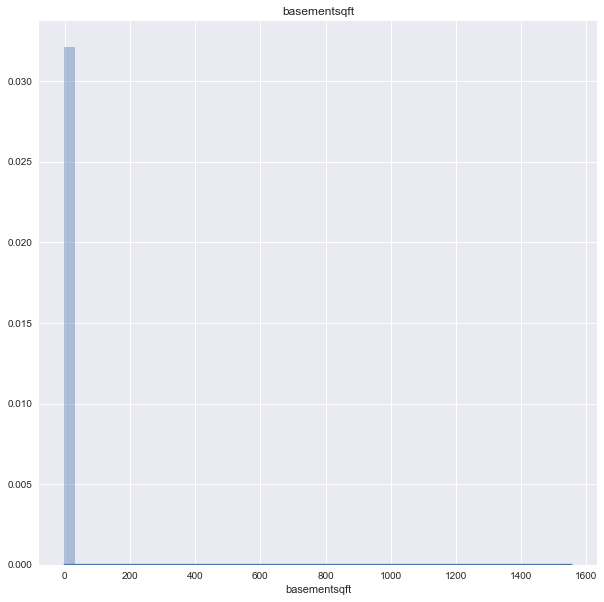

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


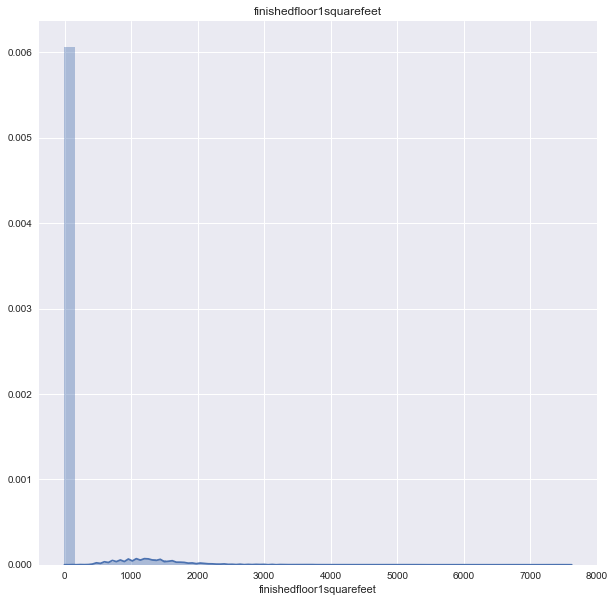

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


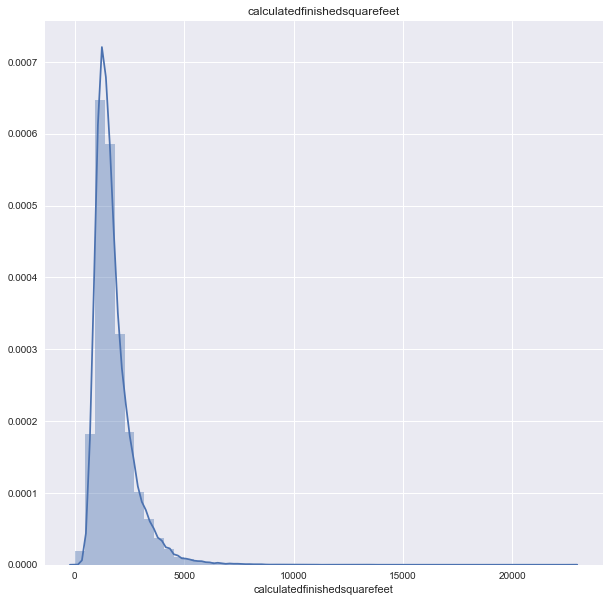

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


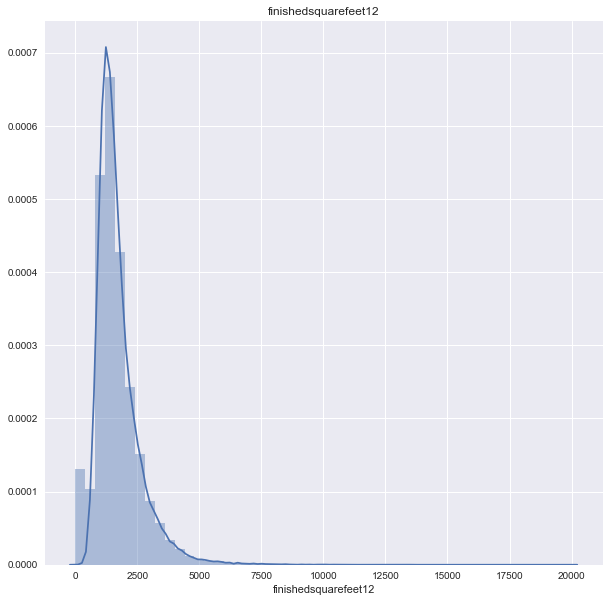

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


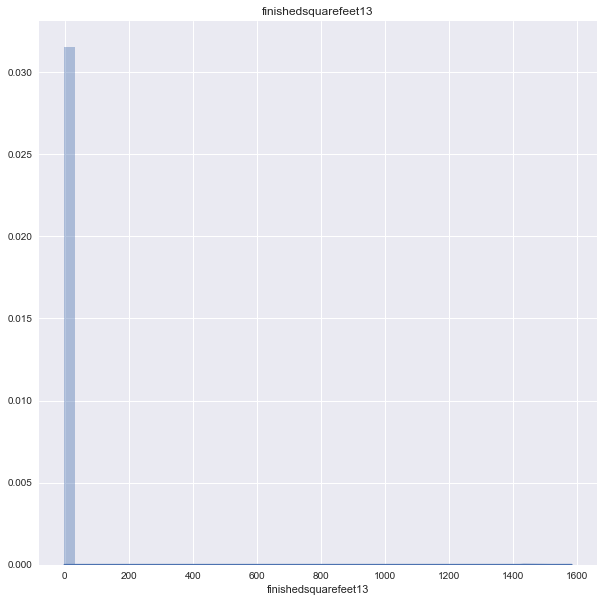

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


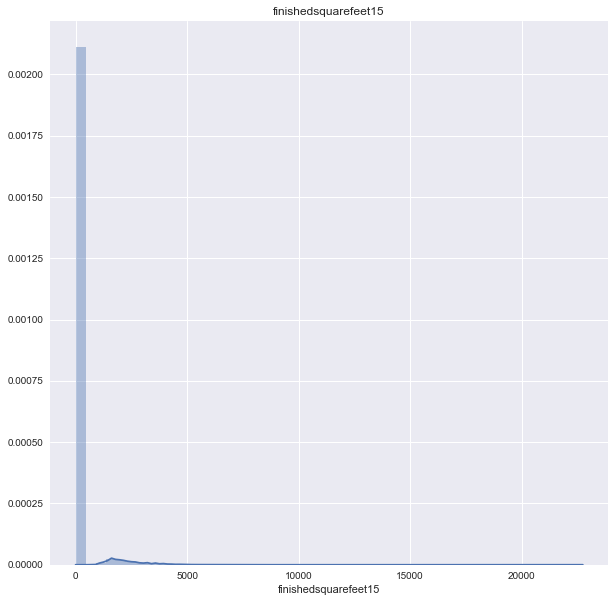

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


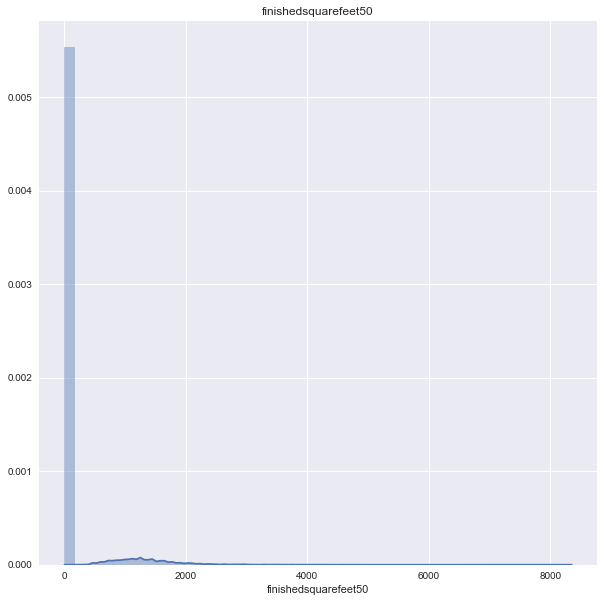

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


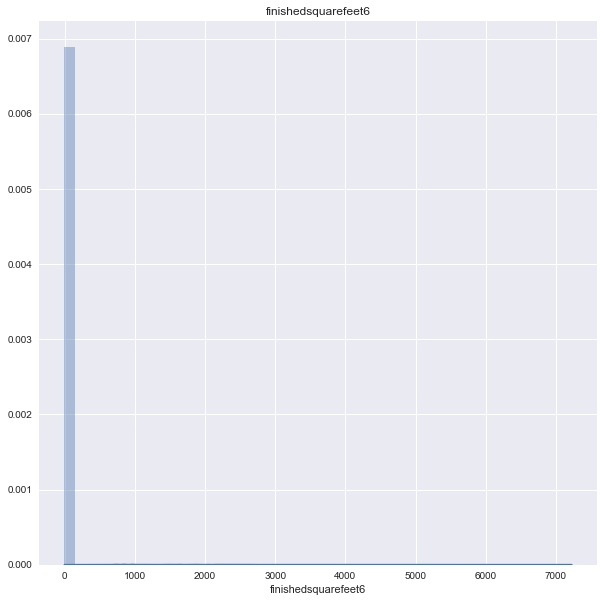

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


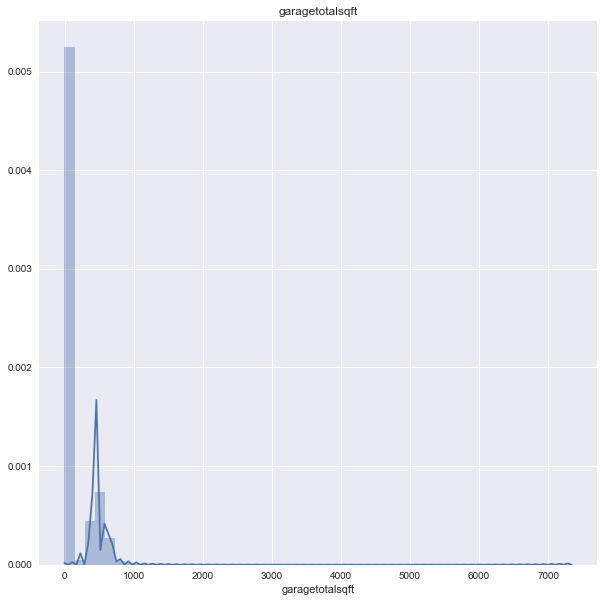

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


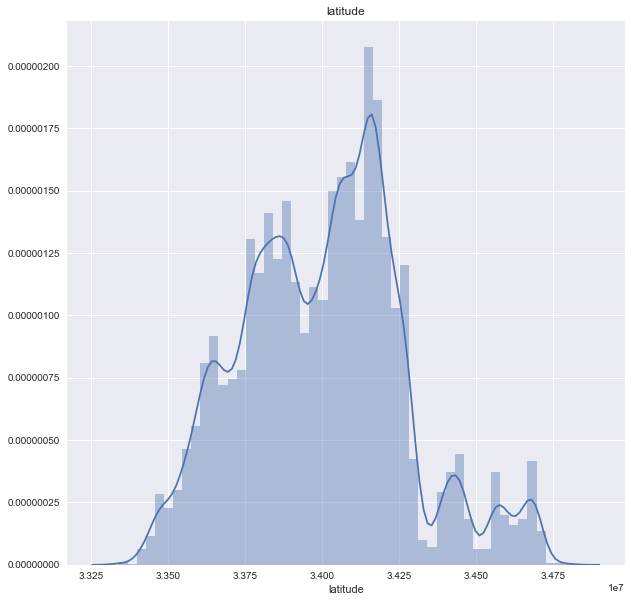

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


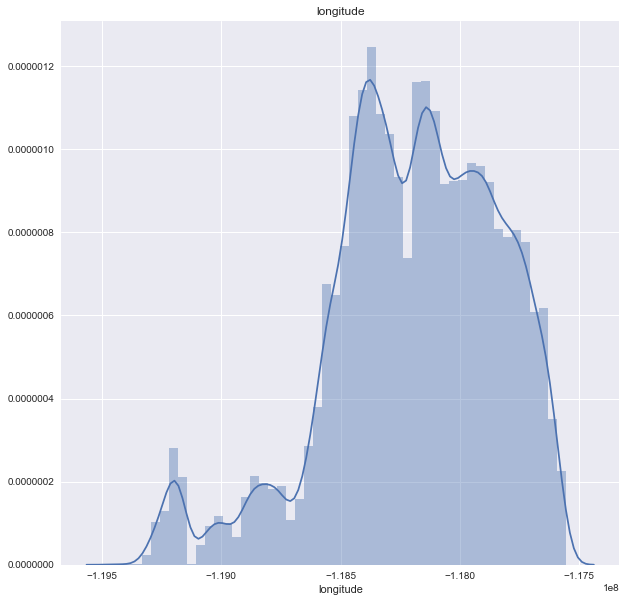

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


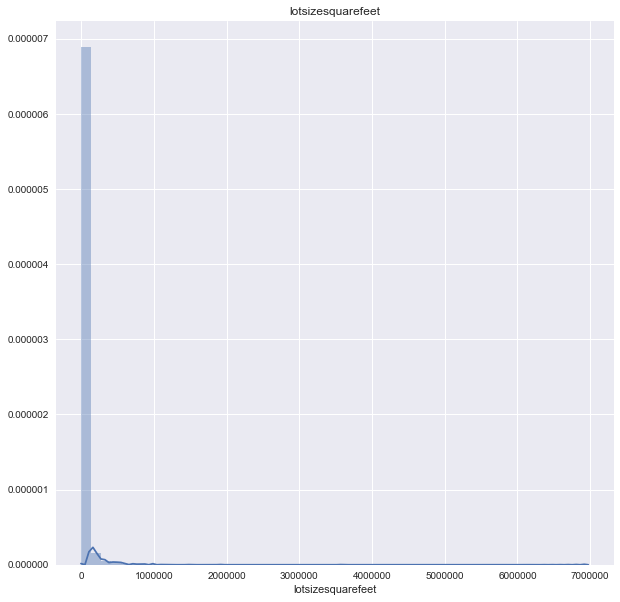

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


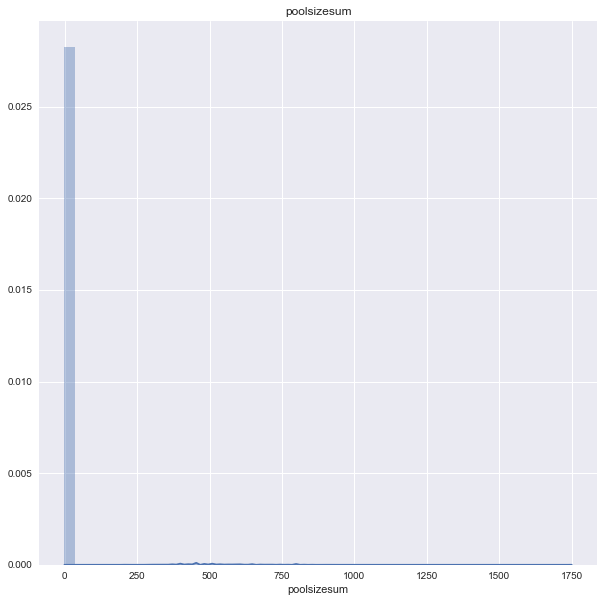

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


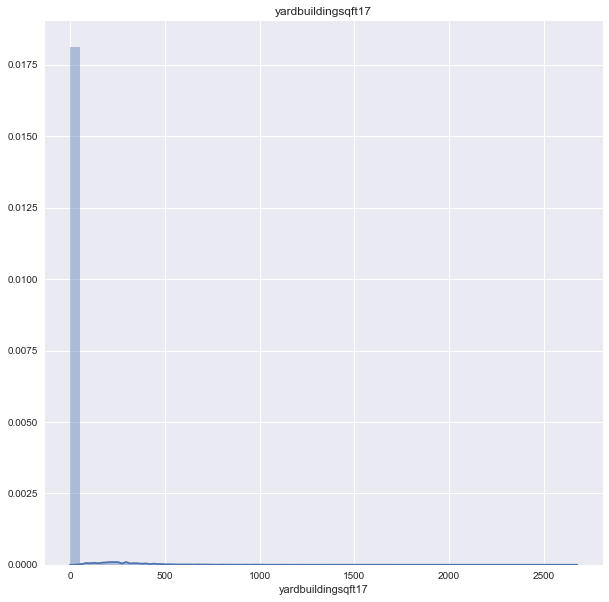

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


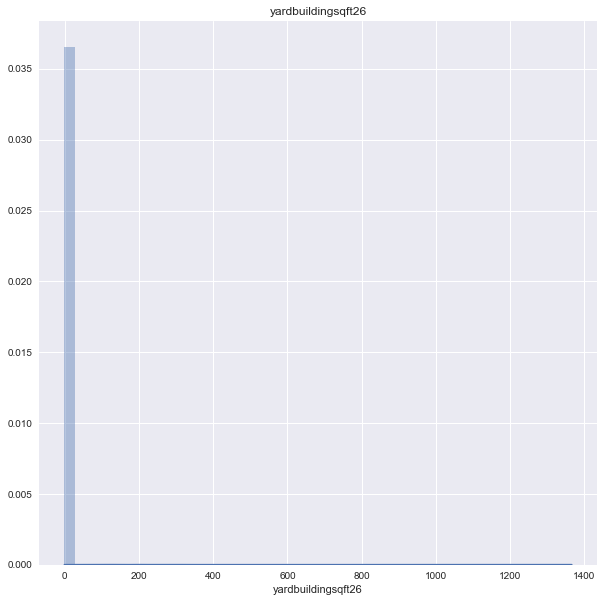

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


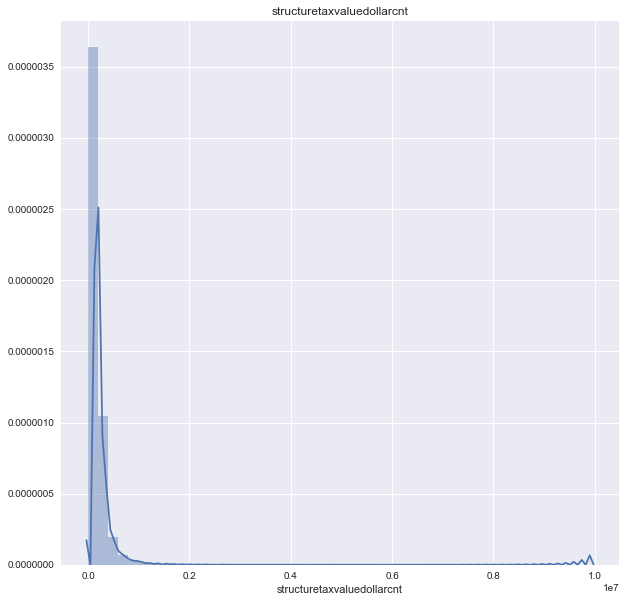

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


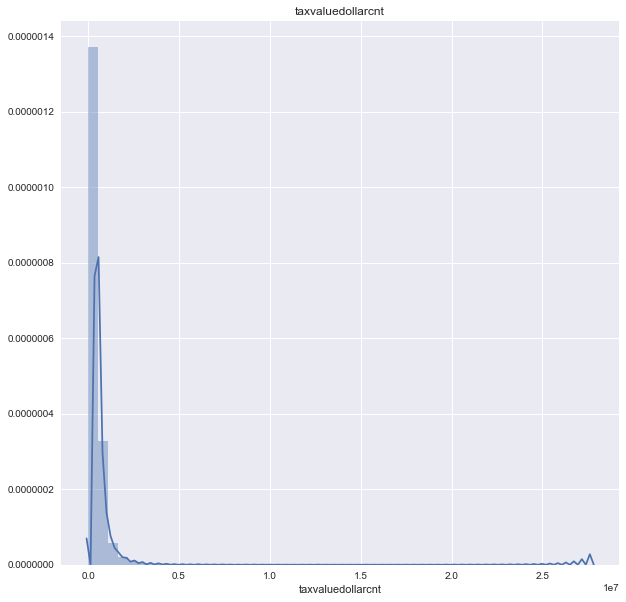

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


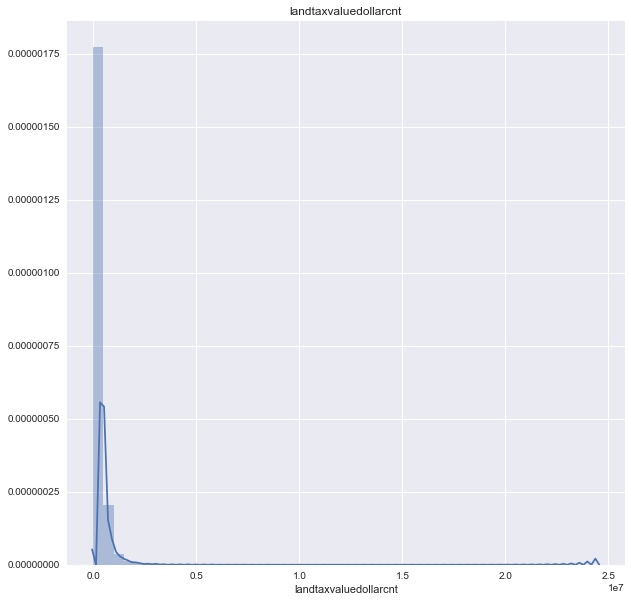

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


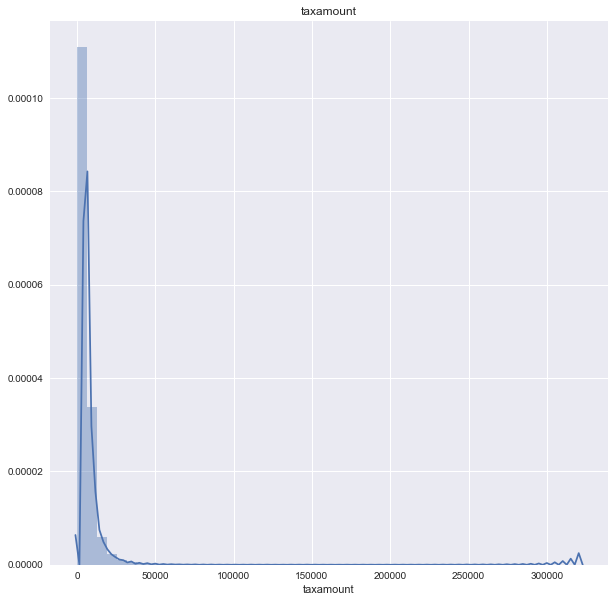

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


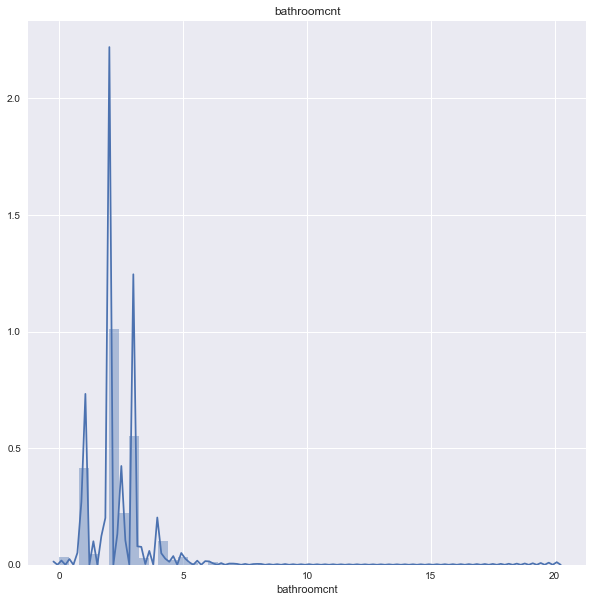

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


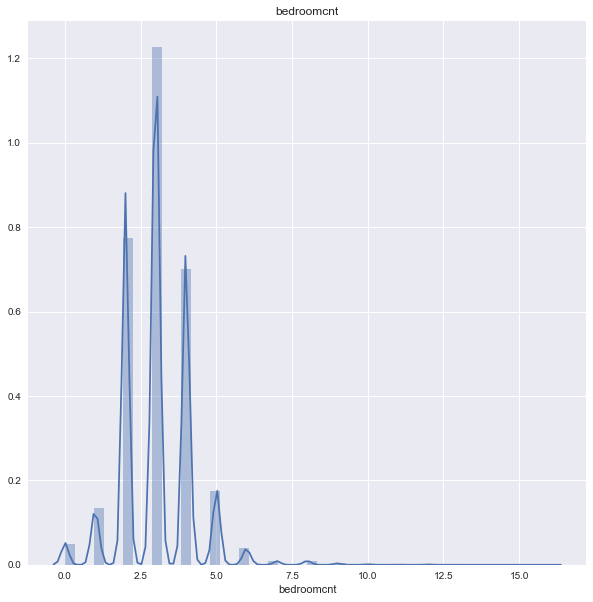

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


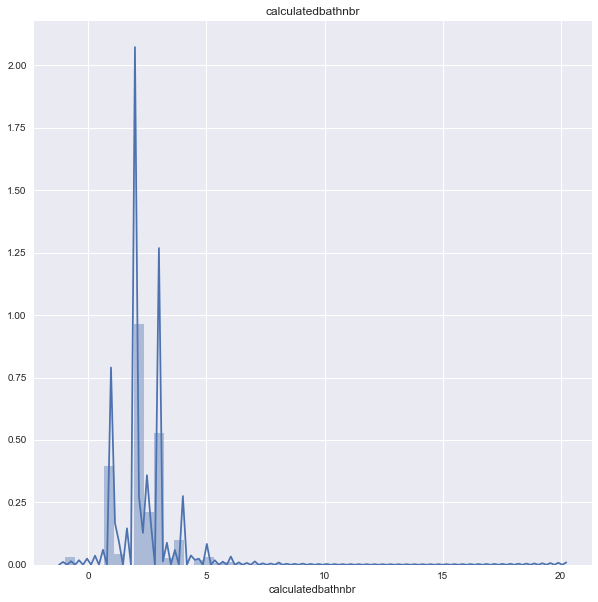

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


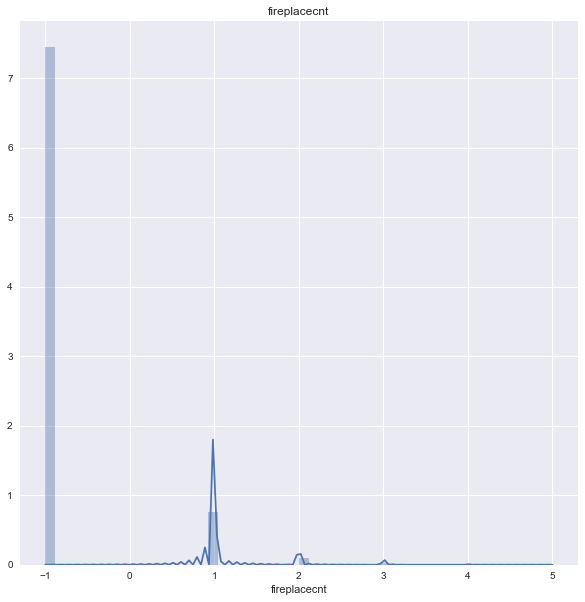

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


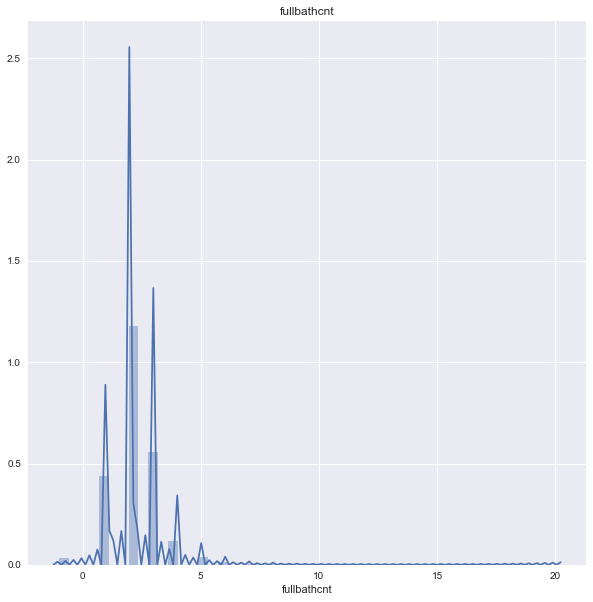

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


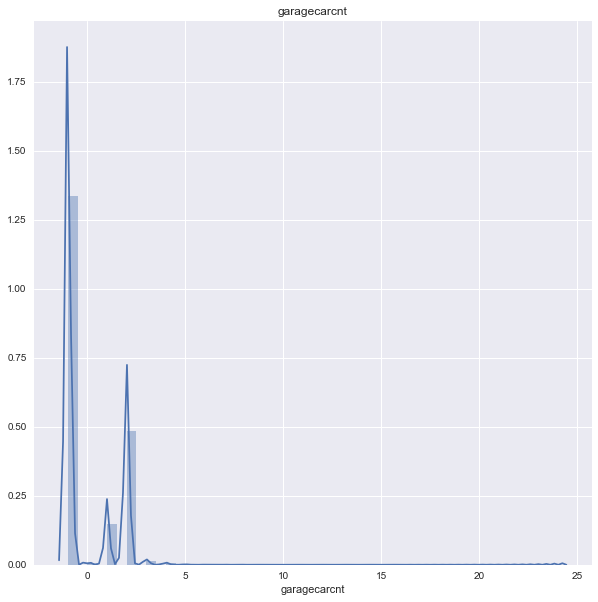

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


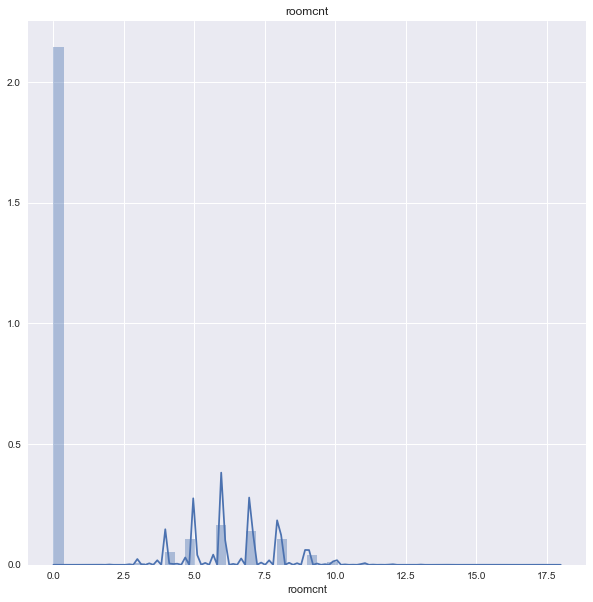

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


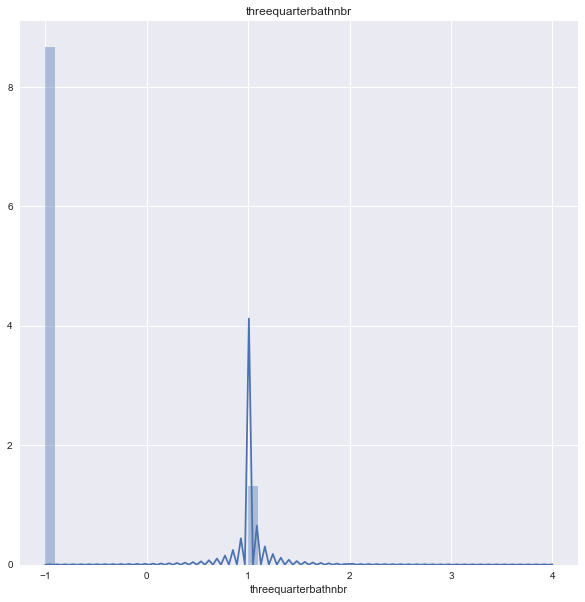

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


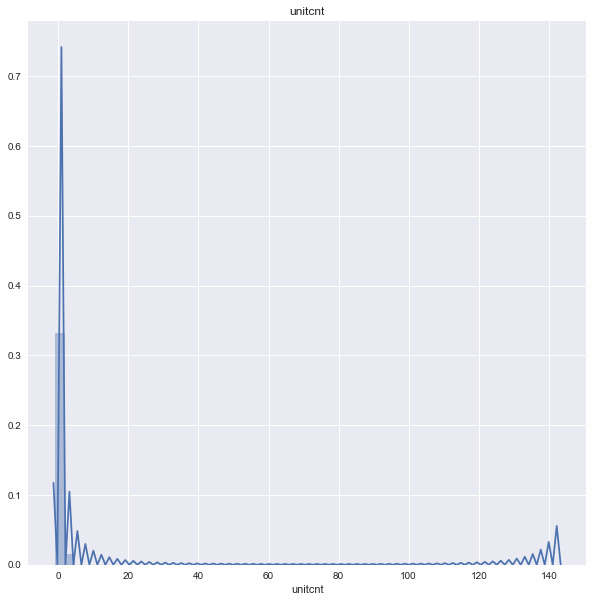

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


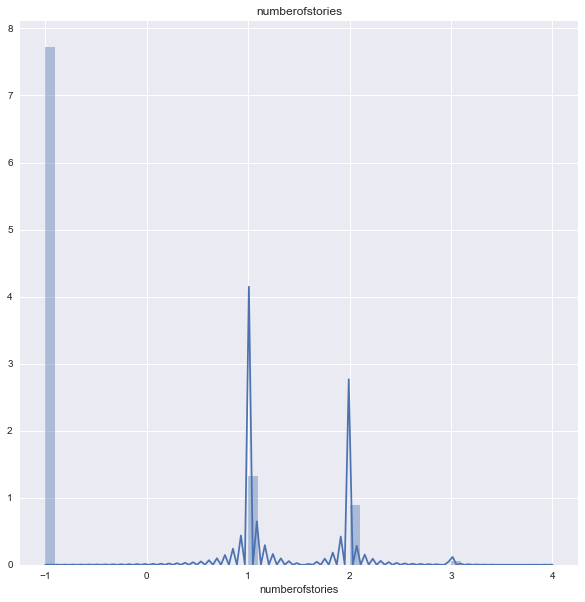

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


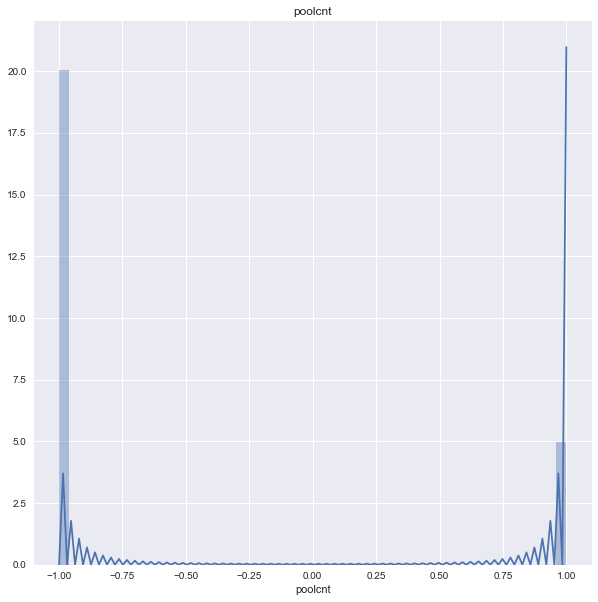

In [41]:
# numeric feature, distplot로 그리기

for feature in feature_num:
    x = num_df[feature]
    plt.title(feature)
    sns.distplot(x)
    plt.show()

##### 독립변수와 종속변수 간 관계 파악하기(scatter plot, distplot, pairplot)

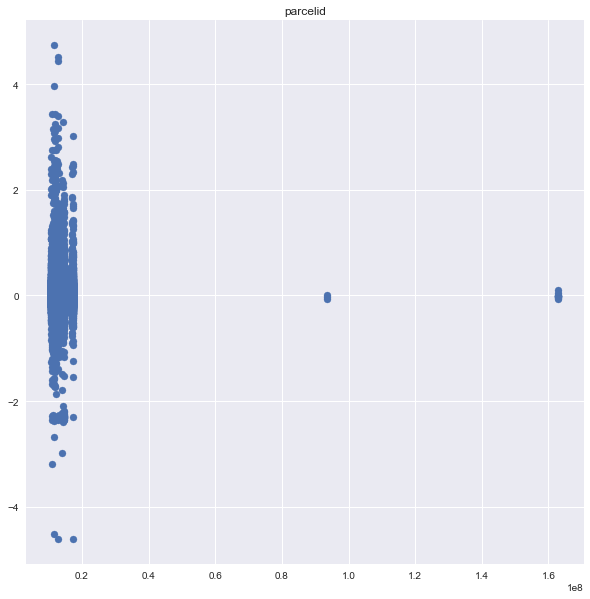

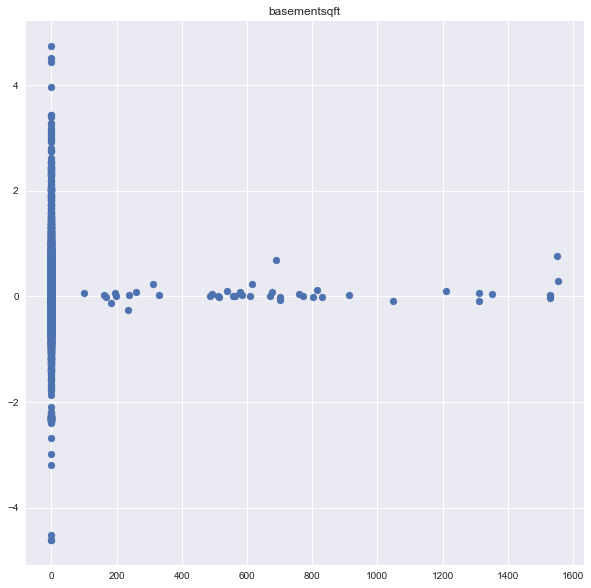

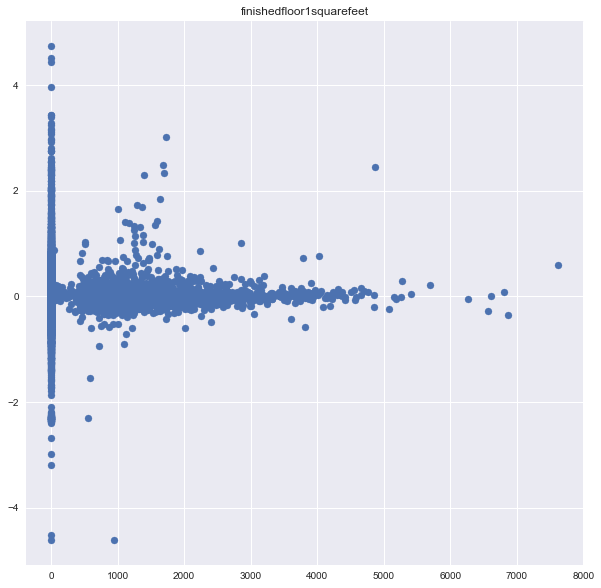

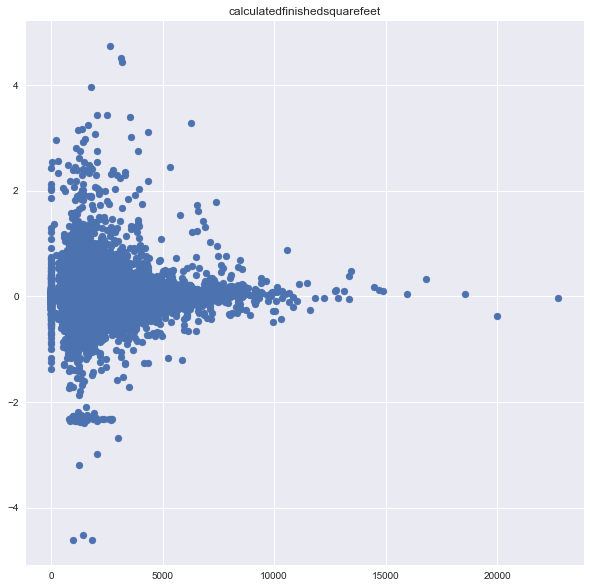

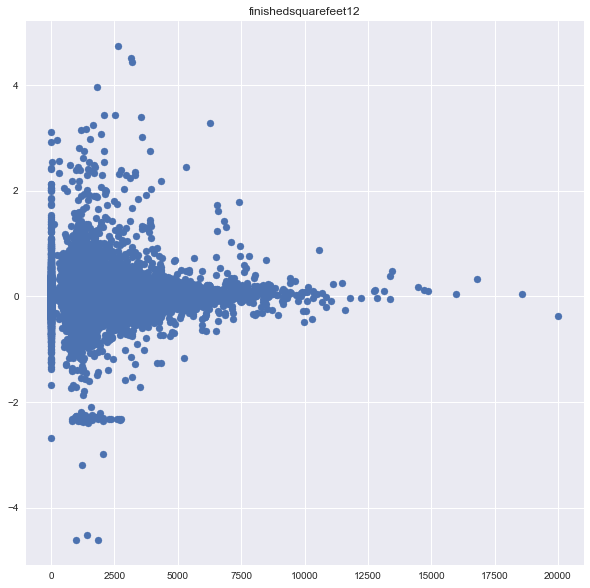

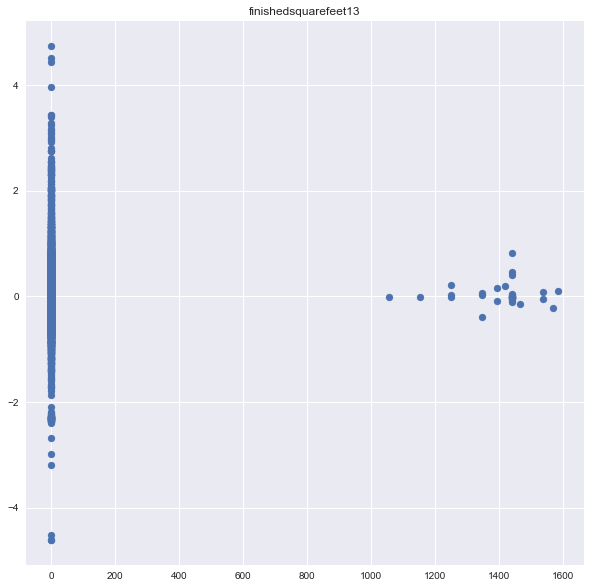

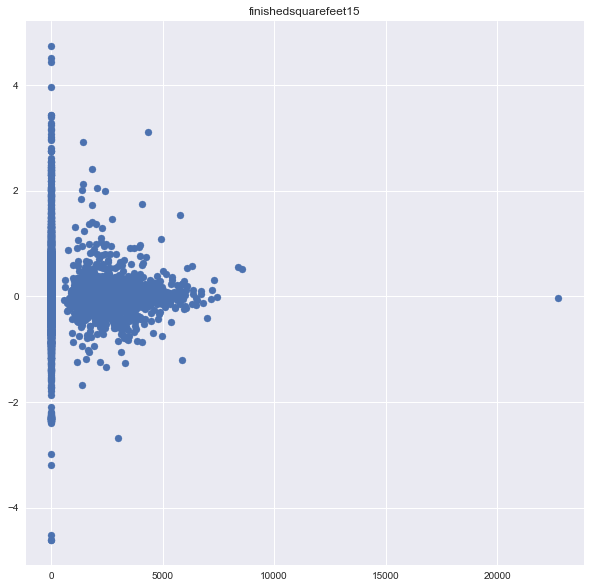

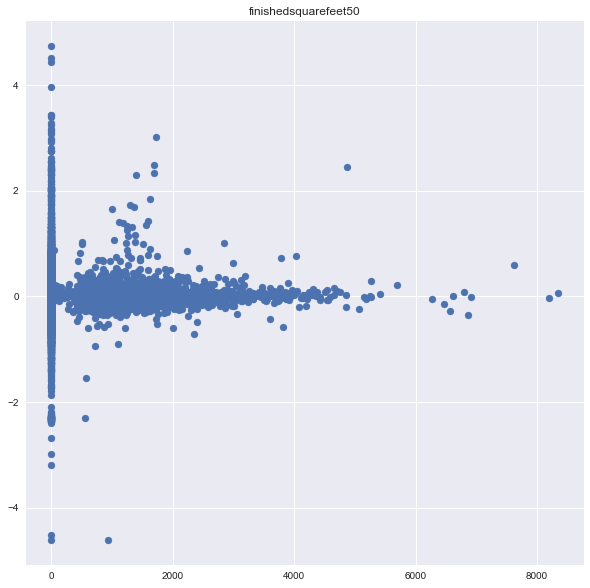

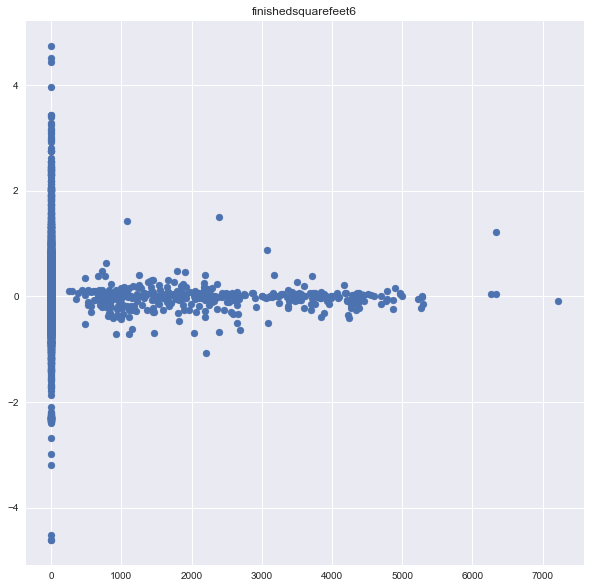

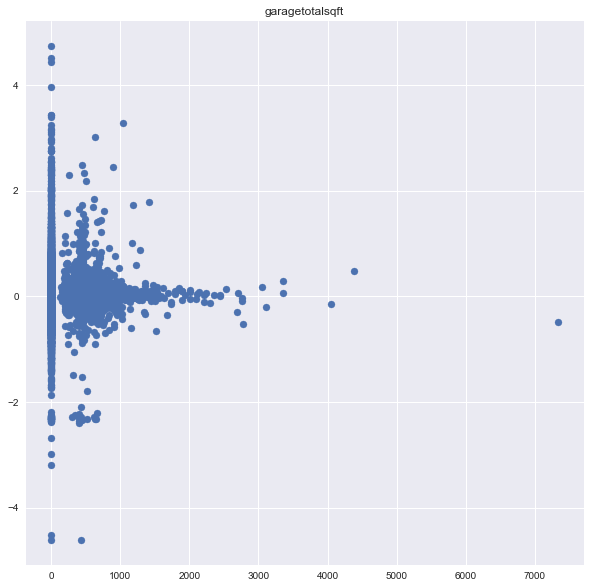

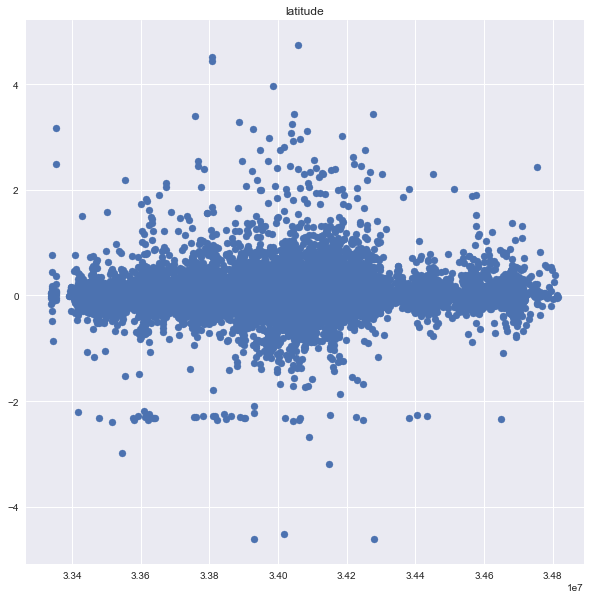

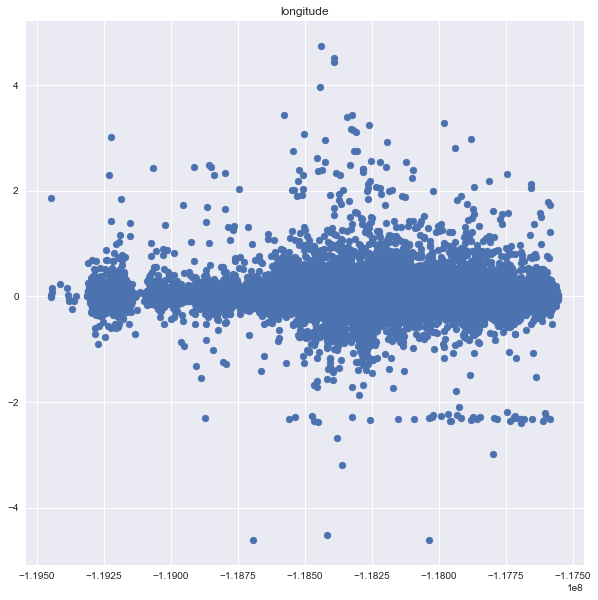

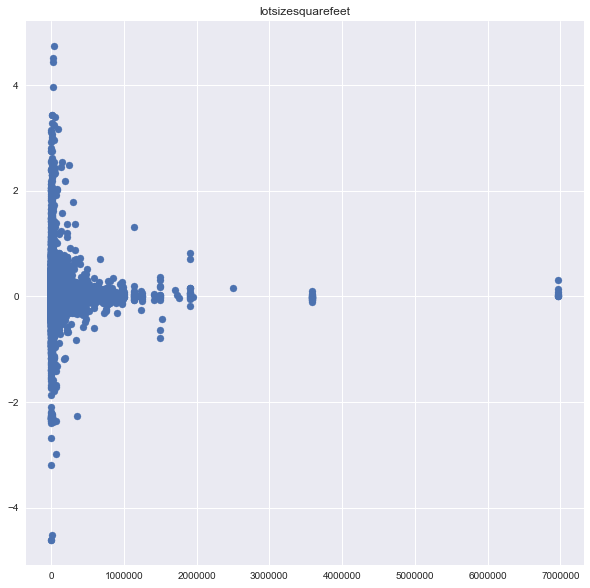

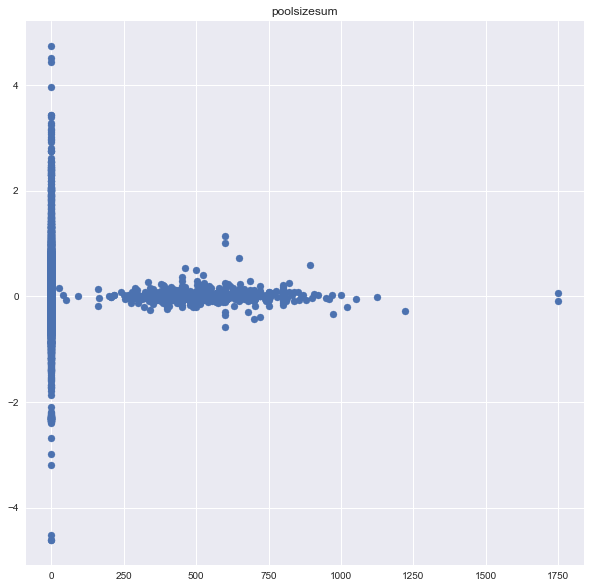

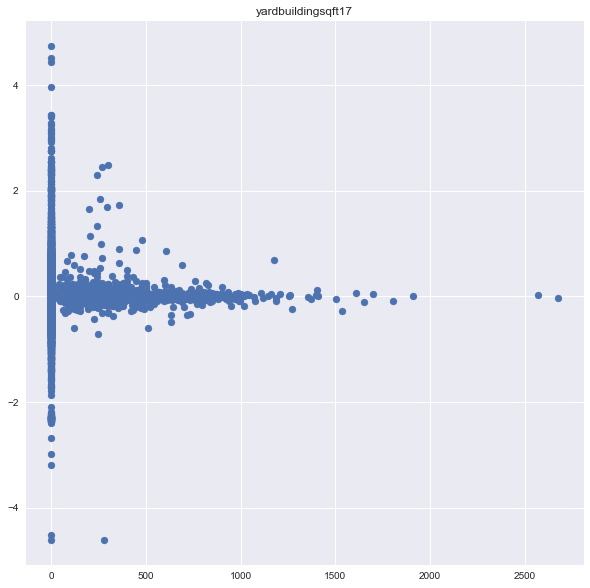

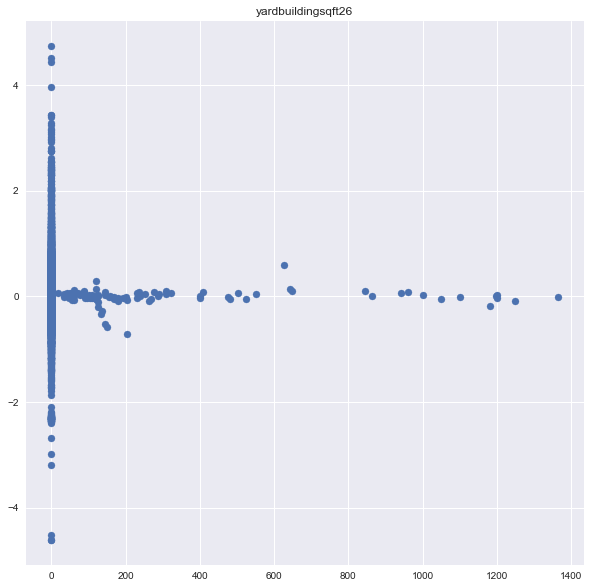

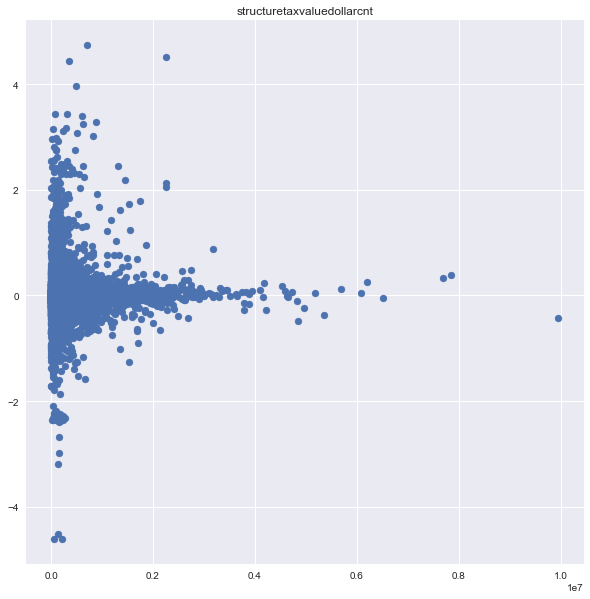

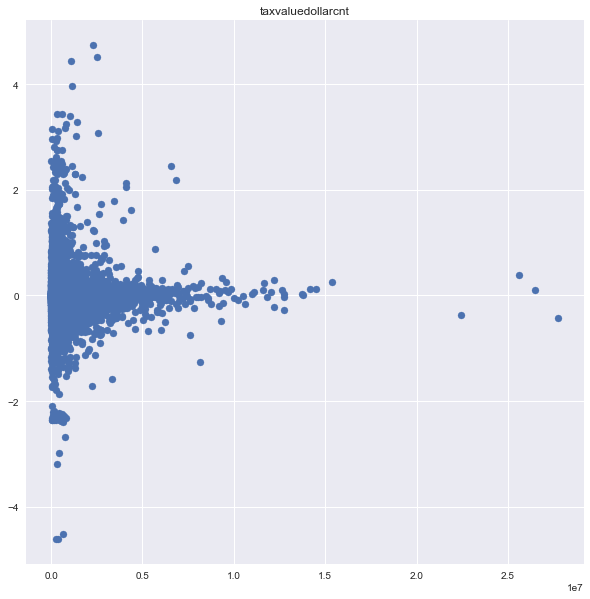

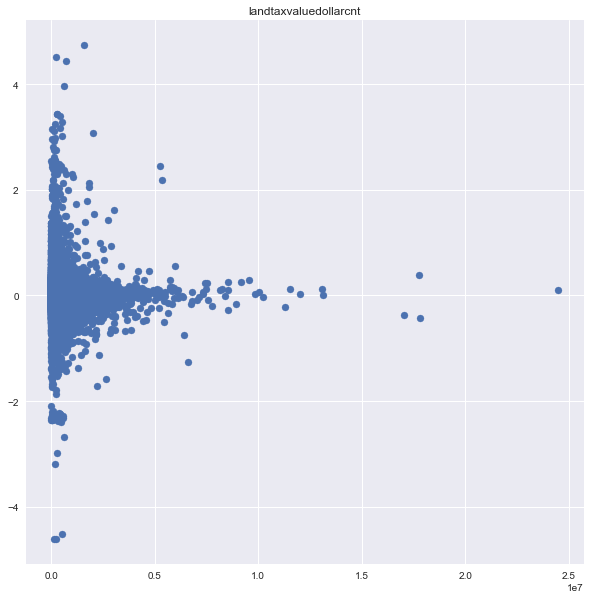

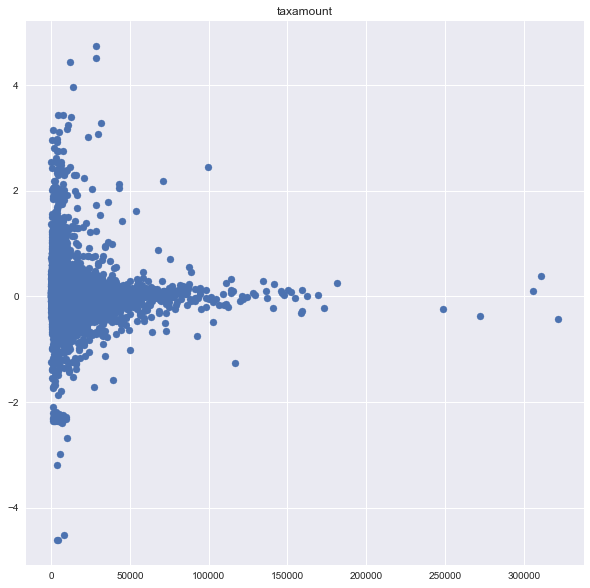

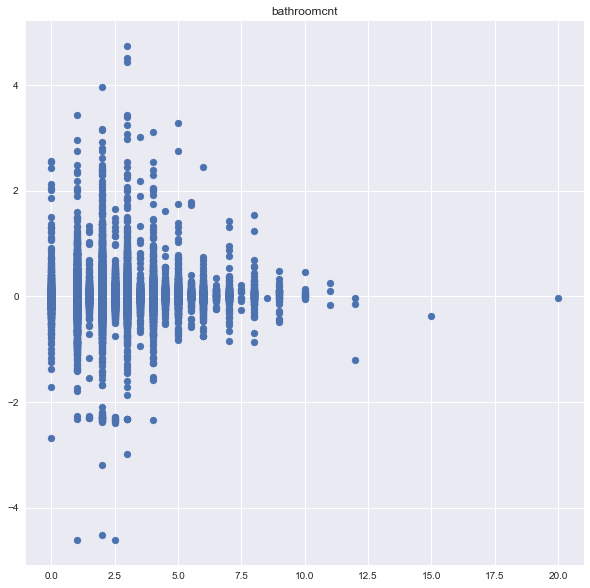

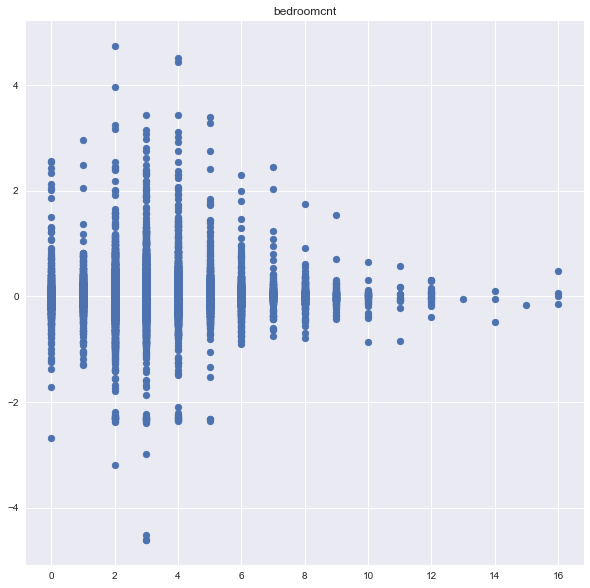

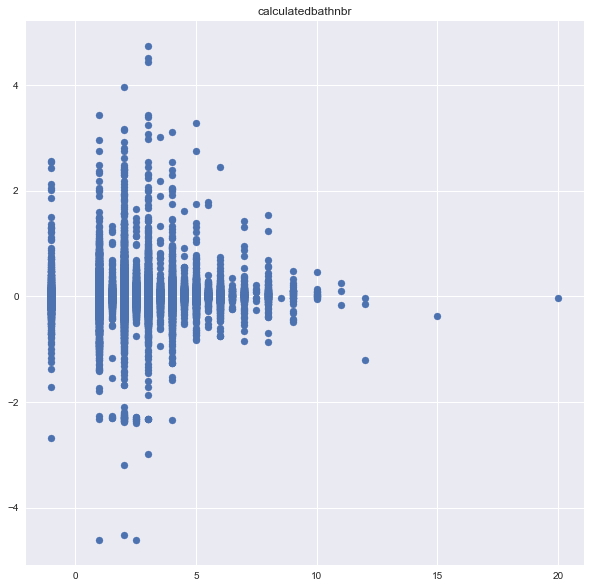

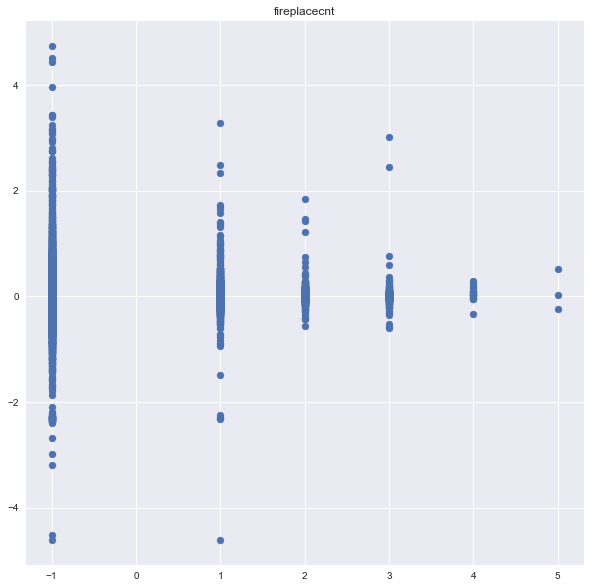

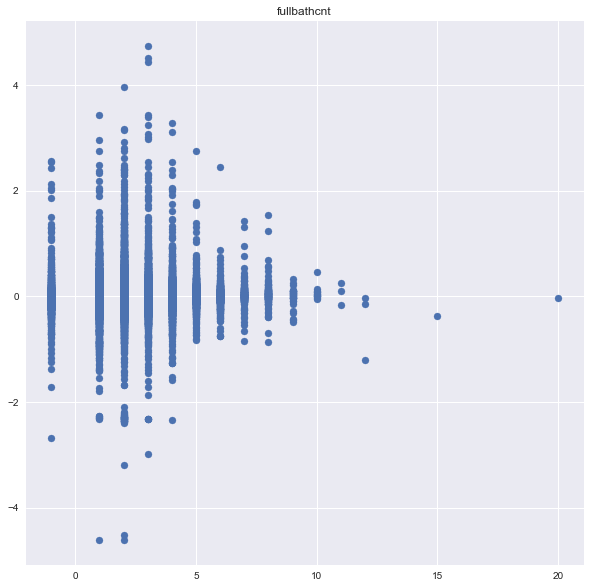

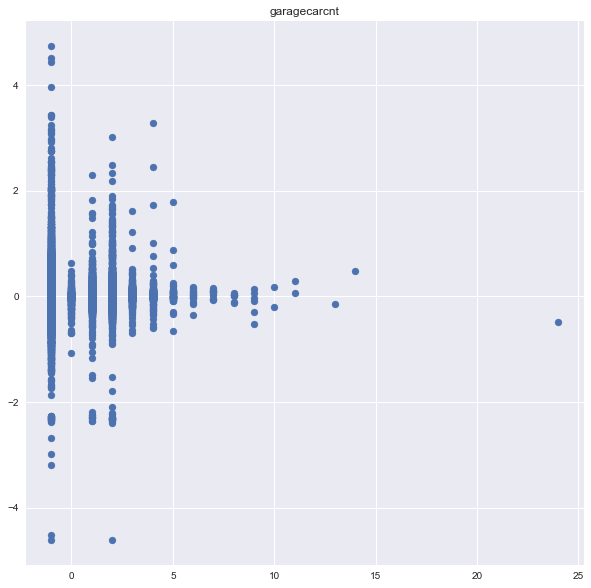

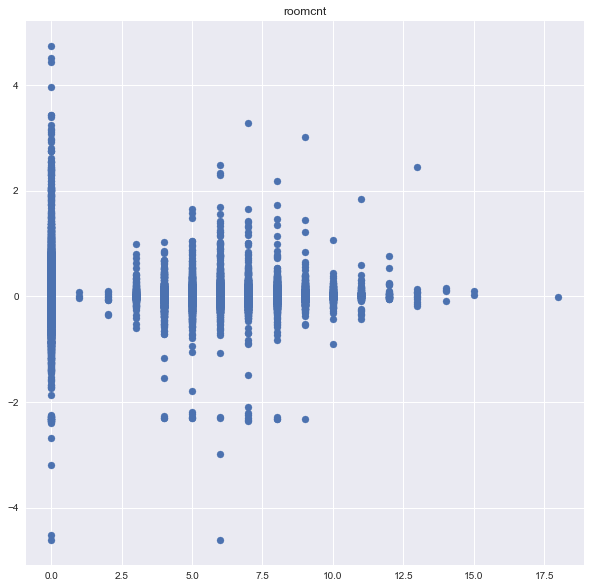

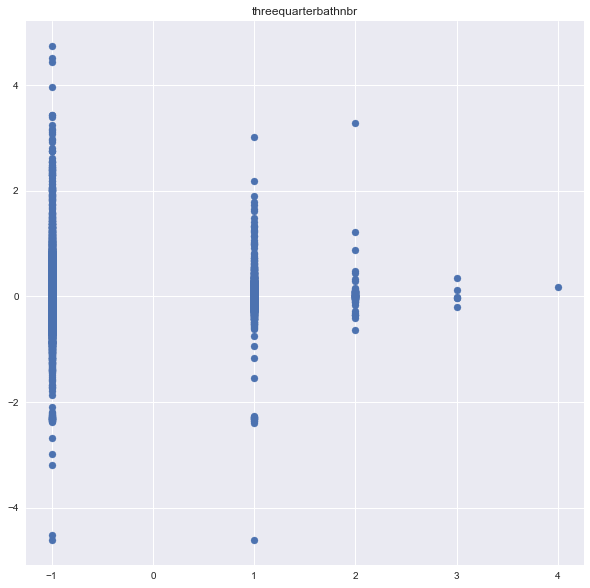

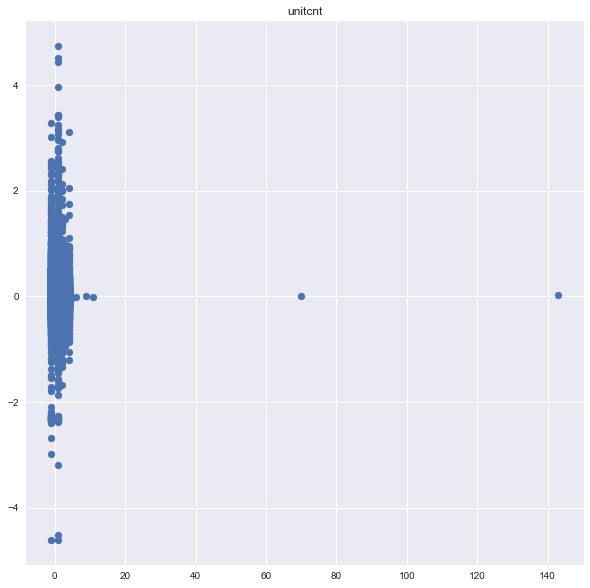

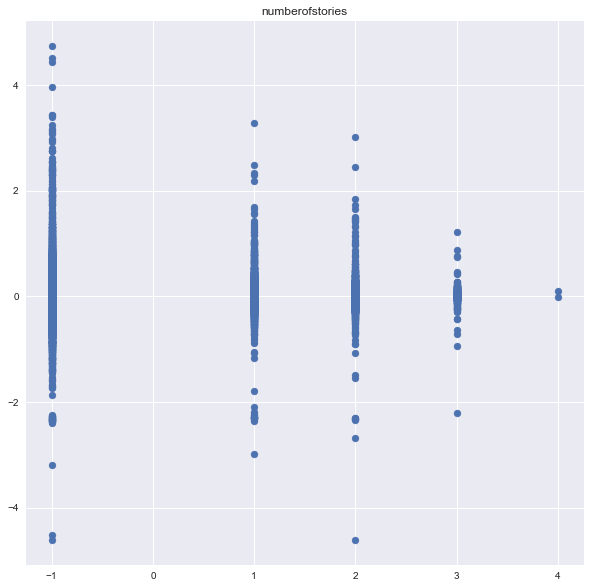

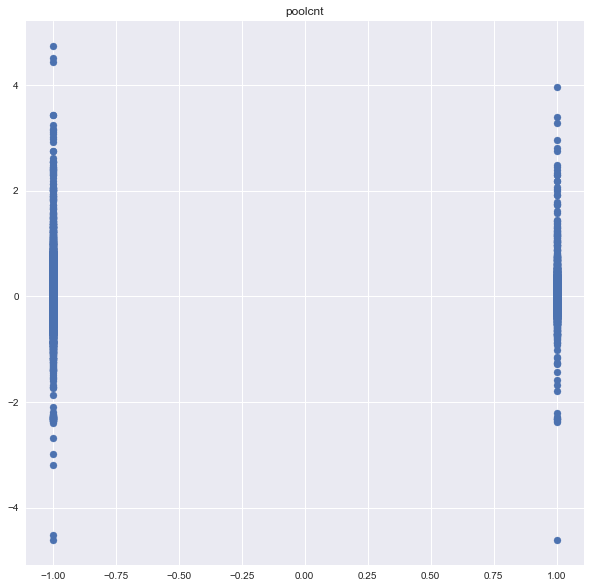

In [42]:
# numeric variable X logerror, scatter plot 그리기

y = df['logerror']

for feature in feature_num:
    x = num_df[feature]
    plt.title(feature)
    plt.scatter(x, y)
    plt.show()

##### numeric variable(cont, discrete) 간 상관계수 구하기(heatmap)

In [43]:
# num_df 에 logerror feature 추가하기

logerror_df = df['logerror']
logerror_df.tail()

90270   -0.0356
90271    0.0070
90272   -0.2679
90273    0.0602
90274    0.4207
Name: logerror, dtype: float64

In [44]:
corr_df = pd.concat([num_df, logerror_df], axis=1)
corr_df.tail()

parcelid  basementsqft  finishedfloor1squarefeet  \
90270  10774160          -1.0                      -1.0   
90271  12046695          -1.0                      -1.0   
90272  12995401          -1.0                      -1.0   
90273  11402105          -1.0                      -1.0   
90274  12566293          -1.0                      -1.0   

       calculatedfinishedsquarefeet  finishedsquarefeet12  \
90270                         653.0                 653.0   
90271                        2856.0                2856.0   
90272                        2617.0                  -1.0   
90273                        1034.0                1034.0   
90274                        1524.0                1524.0   

       finishedsquarefeet13  finishedsquarefeet15  finishedsquarefeet50  \
90270                  -1.0                  -1.0                  -1.0   
90271                  -1.0                  -1.0                  -1.0   
90272                  -1.0                2617.0                  -1.0   
90273                  -1.0                  -1.0                  -1.0   
90274                  -1.0                  -1.0                  -1.0   

       finishedsquarefeet6  garagetotalsqft    ...     calculatedbathnbr  \
90270                 -1.0             -1.0    ...                   1.0   
90271                 -1.0             -1.0    ...                   3.0   
90272                 -1.0             -1.0    ...                   2.0   
90273                 -1.0             -1.0    ...                   2.0   
90274                 -1.0             -1.0    ...                   1.0   

       fireplacecnt  fullbathcnt  garagecarcnt  roomcnt  threequarterbathnbr  \
90270          -1.0          1.0          -1.0      0.0                 -1.0   
90271          -1.0          3.0          -1.0      0.0                 -1.0   
90272          -1.0          2.0          -1.0      0.0                 -1.0   
90273          -1.0          2.0          -1.0      0.0                 -1.0   
90274          -1.0          1.0          -1.0      0.0                 -1.0   

       unitcnt  numberofstories  poolcnt  logerror  
90270      1.0             -1.0      1.0   -0.0356  
90271      1.0             -1.0     -1.0    0.0070  
90272      2.0             -1.0     -1.0   -0.2679  
90273      1.0             -1.0     -1.0    0.0602  
90274      1.0             -1.0     -1.0    0.4207  

[5 rows x 32 columns]

In [45]:
figsize(20, 20)

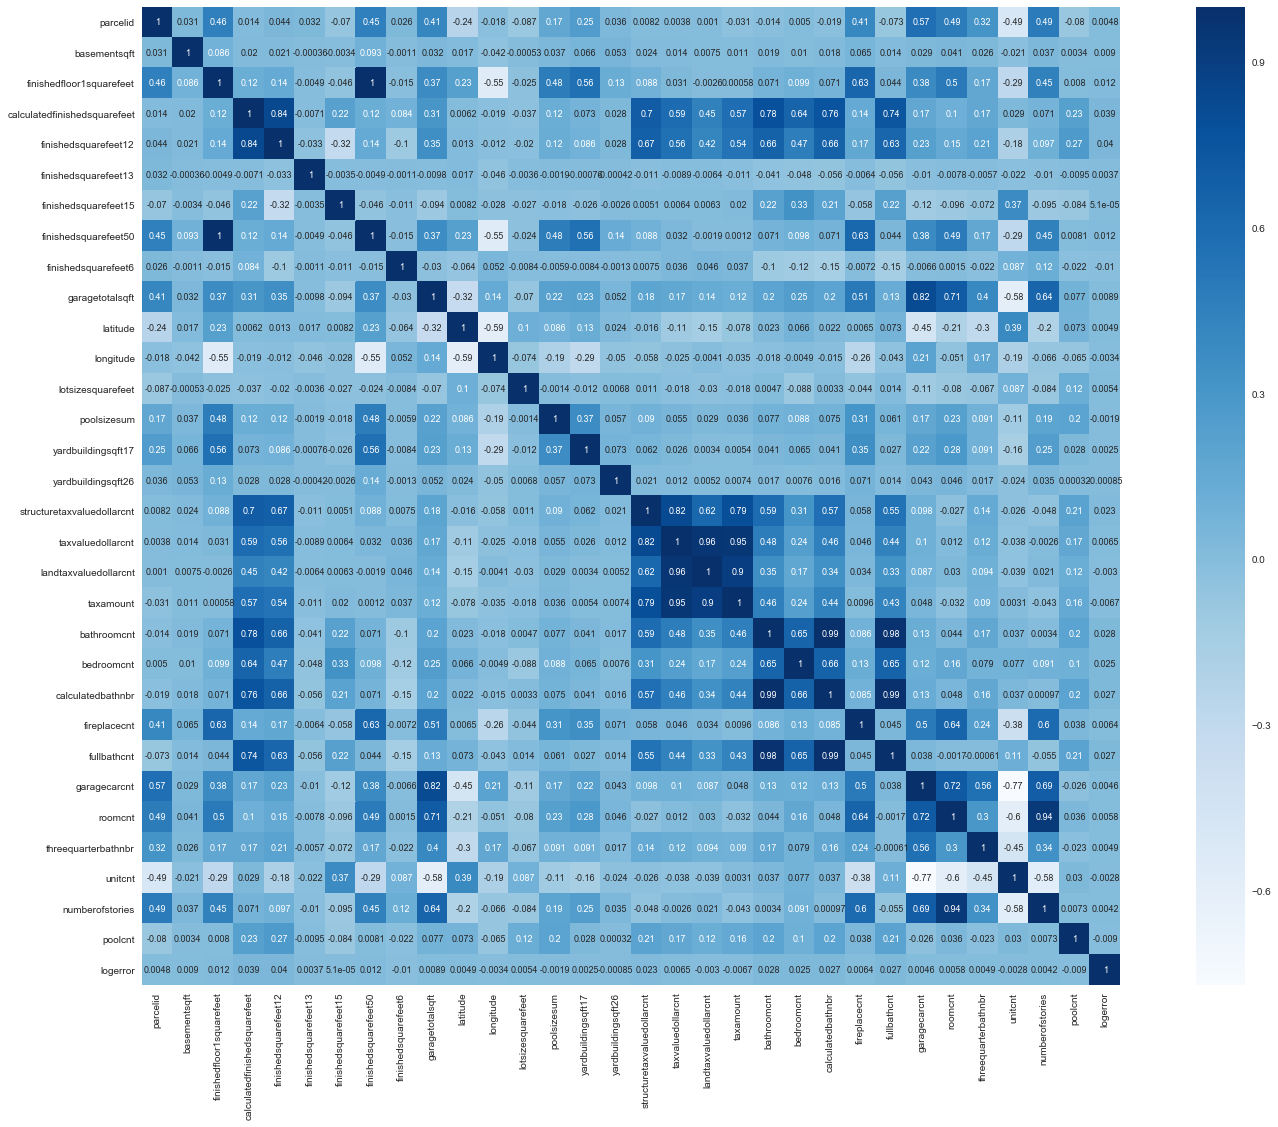

In [46]:
# numeric (heatmap)

corr = corr_df.corr()
fig,ax= plt.subplots()
fig.set_size_inches(27,18)
sns.heatmap(corr, vmax=1., square=True, cmap="Blues", annot=True, annot_kws={"size": 9})
plt.show()

In [47]:
# google sheet에 정리

corr_csv = corr_df.corr()
corr_csv.to_csv('/Users/quartz/Dropbox/zillow-home-value-prediction-trainning/correlation_numeric.csv')

##### 독립 변수 별 Missing Value 수, 분포 파악하기

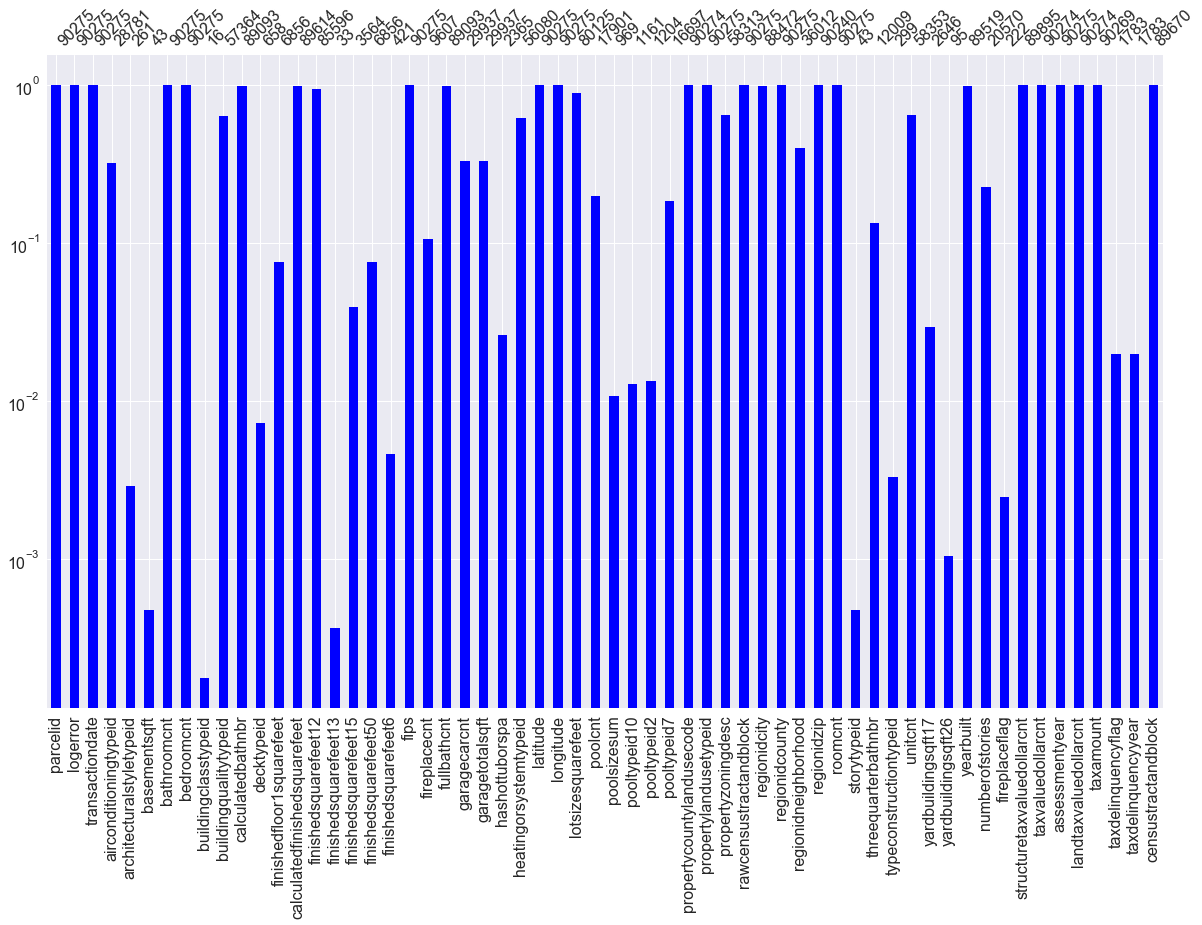

In [48]:
msno.bar(df, color="blue", log=True, figsize=(20, 12))

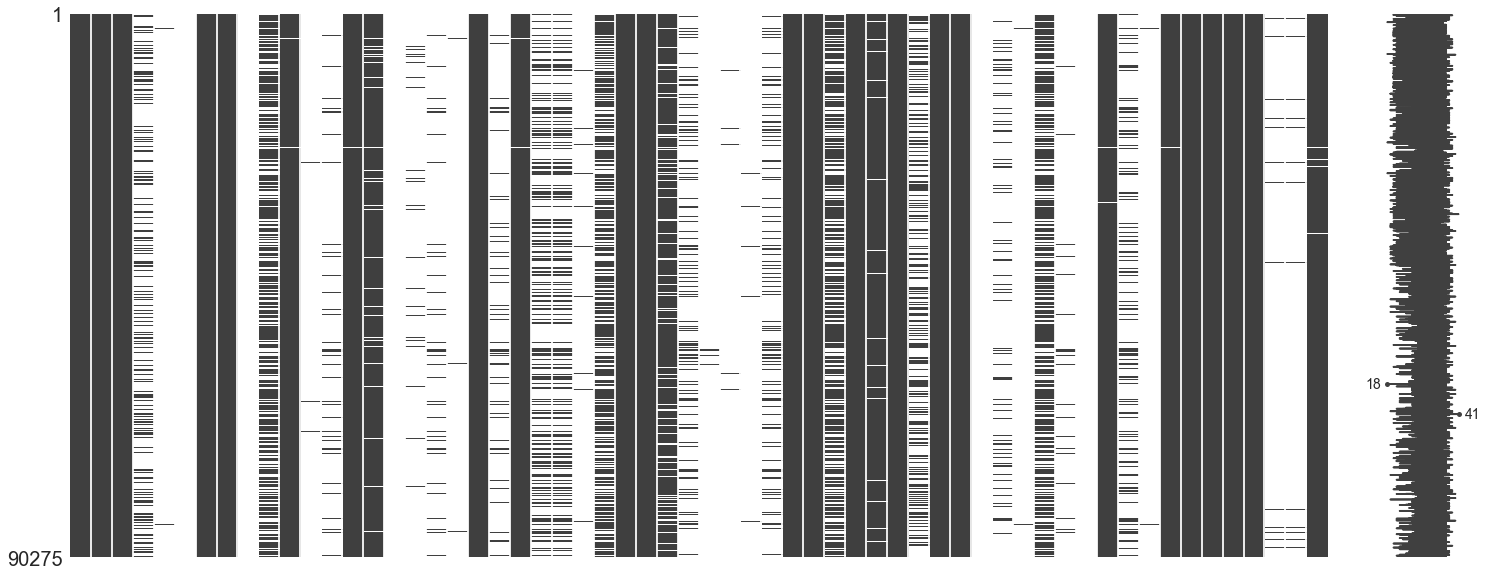

In [49]:
msno.matrix(df)
plt.show()

# 2. Preprocessing
- - -

# 2. 명제 : 선형 회귀분석으로 Log error를 예측할 수 있다.

- - -

In [ ]:
# histo, scatter, box 함수

def histo(name, bins="auto", path="./hists", df=result_df):
    plt.figure(figsize=(10,10))
    plt.hist(df[name].dropna(), bins=bins)
    plt.title("{}_count:{}".format(name, df[name].dropna().count()))
    plt.savefig("{}/{}_hist.png".format(path,name))
    plt.close("all")
       
def scatter(name, path="./scatters", df=result_df):
    plt.figure(figsize=(10,10))
    df1 = df[[name, "R_logerror"]].dropna()
    plt.scatter(df1[name], df1["Z_logerror"], alpha=0.2)
    plt.title("{}  vs  {}  count: {}".format("R_logerror", name, len(df)))
    plt.savefig("{}/scatter_{}.png".format(path,name))
    plt.close("all")
    
def box(name, path="./boxes", df=result_df):
    df1 = df[[name, "Z_logerror"]].dropna()
    fig, ax = plt.subplots(figsize=(20,10))
    df1.boxplot(by=name, ax=ax, sym='')
    ax.margins(y=0.1)
    plt.xticks(rotation=90)
    plt.title("count: {}".format(len(df)))
    plt.savefig("{}/box_{}.png".format(path,name))
    plt.close("all")

## _2 - 1. EDA : Numeric Variable과 Log Error 간 유의미한 상관관계를 찾기 어렵다._

In [ ]:
# logerror의 분포

x = m_data['logerror']
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True ,
                                    gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist, bins=400, kde=False)
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.xlim([-0.3, 0.3])
plt.show()

#### 개별 독립 변수와 종속 변수(logerror) 간 유의미한 관계를 파악하기 어렵다(Numeric Variable 기준)

- 첨부 자료 참고

In [ ]:
# 각 독립 변수와 종속 변수(logerror)의 관계 파악 (scatter plot, box plot)

In [ ]:
Image(filename='scatter_1-9.png', width = 900)

#### 전체 독립 변수와 종속 변수 간 유의미한 상관계수를 찾기 어렵다(Numeric Variable 기준)

In [ ]:
# 전체 변수 간 상관계수 파악 (heatmap)

In [ ]:
Image(filename='corr_heat.png', width = 900)

## _2 - 2. 개별 독립 변수로 OLS 만들기 : 각 변수의 유의확률 - Prob(F) - 이 높거나, 가중치가 크지 않다_

#### Numeric Variable Case 1 : 
#### 개별 독립 변수를 OLS 했을 때의 P(value)
#### 유의확률이 유의수준 (1%) 보다 높아, 각 독립변수의 가중치가 0이라는 귀무가설이 채택된다.(17 / 28)

- 첨부 자료 참고

In [ ]:
Image(filename='ols_1.png', width = 250)

#### Numeric Variable 2 : 
#### 개별 독립 변수를 OLS 했을 때, 가중치 계수 취합
#### 선형회귀 계수가 대부분 0.01보다 작아, 독립 변수가 종속 변수(logerror)에 큰 영향을 끼치지 않는다. (10 / 28)

- 첨부 자료 참고

In [ ]:
Image(filename='ols_2.png', width = 270)

#### Category Variable Case : 
#### 개별 독립 변수를 OLS 했을 때, F 값의 유의확률 취합 결과
#### 유의확률이 유의수준 (1%) 보다 높아, 각 독립변수의 가중치가 0이라는 귀무가설이 채택된다.(13 / 25)

- 첨부 자료 참고

In [ ]:
Image(filename='cat.png', width = 300)

## _2-3. 전체 독립 변수로 OLS 만들기_ :  _R-squared, VIFs, 잔차 정규성_

In [ ]:
# 1차 모델 (All)

In [ ]:
# 회귀분석을 위한 formula 제작 툴 (numeric)

formula1 = 'logerror ~ '    
for feature in num_features:
    formula1 += "scale(" + feature + ") + "
formula1 = formula1[:-3]
formula1

In [ ]:
# 회귀분석을 위한 formula 제작 툴 (cat)

formula2 = 'logerror ~ '    
for feature in cat_features:
    formula2 += "C(" + feature + ") + "
formula2 = formula2[:-3]
formula2

In [ ]:
# formula 만들기

formula = 'logerror ~ scale(parcelid) + scale(basementsqft) + scale(bathroomcnt) + scale(bedroomcnt) \
+ scale(calculatedbathnbr) + scale(calculatedfinishedsquarefeet) + scale(finishedfloor1squarefeet) \
+ scale(finishedsquarefeet12) + scale(finishedsquarefeet13) + scale(finishedsquarefeet15) \
+ scale(finishedsquarefeet50) + scale(finishedsquarefeet6) + scale(fireplacecnt) \
+ scale(fullbathcnt) + scale(garagecarcnt) + scale(garagetotalsqft) \
+ scale(landtaxvaluedollarcnt) + scale(lotsizesquarefeet) + scale(numberofstories) \
+ scale(poolcnt) + scale(poolsizesum) + scale(roomcnt) + scale(structuretaxvaluedollarcnt) \
+ scale(taxamount) + scale(taxvaluedollarcnt) + scale(threequarterbathnbr) + scale(unitcnt) \
+ scale(yardbuildingsqft17) + scale(yardbuildingsqft26) \
+ C(buildingqualitytypeid) + C(fips) + C(hashottuborspa) + C(heatingorsystemtypeid) \
+ C(propertycountylandusecode) + C(propertylandusetypeid) + C(propertyzoningdesc) \
+ C(regionidcity) + C(regionidcounty) + C(regionidneighborhood) + C(regionidzip) \
+ C(taxdelinquencyflag)'

model = sm.OLS.from_formula(formula, data=result_df)
result = model.fit()
print(result.summary())

### _결론 : 선형회귀 분석으로 zestimate의 log error를 예측하기 어렵다_
- - -

#### (i) R-squared(Ajd. R-squared)가 3% 미만이다.
#### (ii) 일부 독립 변수는 매우 높은 VIF Factors를 가지고 있어, 다중공선성을 야기한다.
#### (iii) QQ plot, residual plot을 그려도 잔차 정규성을 입증할 수 없다.

#  3. To Improve Performance

## _3-1. 변수 변환_

`unitcnt, yardbuildingsqft26, landtaxvaluedollarcnt, taxamount, lotsizesquarefeet, poolsizesum`를 log 취함
- Before : `0.0288211603887`


- After : `0.0315055370635`


In [ ]:
formula = 'logerror ~ scale(parcelid) + scale(basementsqft) + scale(bathroomcnt) + scale(bedroomcnt) \
+ scale(calculatedbathnbr) + scale(calculatedfinishedsquarefeet) + scale(finishedfloor1squarefeet) \
+ scale(finishedsquarefeet12) + scale(finishedsquarefeet13) + scale(finishedsquarefeet15) \
+ scale(finishedsquarefeet50) + scale(finishedsquarefeet6) + scale(fireplacecnt) \
+ scale(fullbathcnt) + scale(garagecarcnt) + scale(garagetotalsqft) \
+ scale(np.log(landtaxvaluedollarcnt)) + scale(np.log(lotsizesquarefeet)) + scale(numberofstories) \
+ scale(poolcnt) + scale(np.log(poolsizesum)) + scale(roomcnt) + scale(structuretaxvaluedollarcnt) \
+ scale(np.log(taxamount)) + scale(taxvaluedollarcnt) + scale(threequarterbathnbr) + scale(np.log(unitcnt)) \
+ scale(yardbuildingsqft17) + scale(np.log(yardbuildingsqft26)) \
+ C(buildingqualitytypeid) + C(fips) + C(hashottuborspa) + C(heatingorsystemtypeid) \
+ C(propertycountylandusecode) + C(propertylandusetypeid) + C(propertyzoningdesc) \
+ C(regionidcity) + C(regionidcounty) + C(regionidneighborhood) + C(regionidzip) \
+ C(taxdelinquencyflag)'

model = sm.OLS.from_formula(formula, data=result_df)
result = model.fit()
print(result.summary())

In [ ]:
# 자료 첨부

## _3-2. Cond Num : VIF_

- contion n : `1.33e+16 >> 1.23e+16` 

- r squared : `0.032 >> 0.031`


    1. taxvaluedollarcnt
    2. poolcnt
    3. longitude
    4. latitude
    5. calculatedbathnbr
    6. basementsqft
    7. finishedfloor1squarefeet
    8. poolsizesum
    9. yardbuildingsqft26
    10. calculatedfinishedsquarefeet

In [ ]:
formula = 'logerror ~ scale(parcelid) + scale(bathroomcnt) + scale(bedroomcnt) \
+ scale(finishedsquarefeet12) + scale(finishedsquarefeet13) + scale(finishedsquarefeet15) \
+ scale(finishedsquarefeet50) + scale(finishedsquarefeet6) + scale(fireplacecnt) \
+ scale(fullbathcnt) + scale(garagecarcnt) + scale(garagetotalsqft) \
+ scale(np.log(landtaxvaluedollarcnt)) + scale(np.log(lotsizesquarefeet)) + scale(numberofstories) \
+ scale(roomcnt) + scale(structuretaxvaluedollarcnt) \
+ scale(np.log(taxamount)) + scale(threequarterbathnbr) + scale(np.log(unitcnt)) \
+ scale(yardbuildingsqft17) \
+ C(buildingqualitytypeid) + C(fips) + C(hashottuborspa) + C(heatingorsystemtypeid) \
+ C(propertycountylandusecode) + C(propertylandusetypeid) + C(propertyzoningdesc) \
+ C(regionidcity) + C(regionidcounty) + C(regionidneighborhood) + C(regionidzip) \
+ C(taxdelinquencyflag)'

model = sm.OLS.from_formula(formula, data=result_df)
result = model.fit()
print(result.summary())

## _3-4. 다항 회귀_

F-test 통해서 카테고리를 select 후, interaction 

- 다항회귀 : `0.0321759891333`
- interaction : 

In [ ]:
Image(filename='summary_1.png', width = 700)

In [ ]:
Image(filename='summary_2.png', width = 700)

In [ ]:
Image(filename='kaggle_result.png', width = 900)

In [ ]:
# 잔차 정규성 확인

In [ ]:
Image(filename='residual normality.png', width = 500)

# Chi^2       : 63769.607
# P-value     :  0.000

### Zestimate의 Log error를 예측하기 위해 다른 방법을 고려한다.

# 4. 선형회귀모형 외 가능한 방법들
- - -

### XGBoost 
### LightGBM